In [1]:
import pandas as pd
from art_api import config, utils, trainer, preproc
import wandb
from wandb.keras import WandbCallback
import os
from google.cloud import storage
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, layers, models
from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path
from wandb.keras import WandbCallback
from matplotlib import pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input as preproc_vgg16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as preproc_vgg19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input as preproc_resnet
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as preproc_inception
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preproc_inceptionv2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as preproc_xception
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
os.environ['WANDB_NOTEBOOK_NAME'] = "trainer notebook"

# Load dataset and get X and y

In [2]:
imgs, df = utils.init()

In [3]:
df

index                                          Image URL  \
0         0  https://d3d00swyhr67nd.cloudfront.net/w1200h12...   
1         1  https://d3d00swyhr67nd.cloudfront.net/w1200h12...   
2         2  https://d3d00swyhr67nd.cloudfront.net/w1200h12...   
3         3  https://d3d00swyhr67nd.cloudfront.net/w1200h12...   
4         4  https://d3d00swyhr67nd.cloudfront.net/w1200h12...   
...     ...                                                ...   
8291   8623  https://d3d00swyhr67nd.cloudfront.net/w944h944...   
8292   8625  https://d3d00swyhr67nd.cloudfront.net/w1200h12...   
8293   8626  https://d3d00swyhr67nd.cloudfront.net/w1200h12...   
8294   8627  https://d3d00swyhr67nd.cloudfront.net/w944h944...   
8295   8628  https://d3d00swyhr67nd.cloudfront.net/w944h944...   

                                           Web page URL   Subset  \
0     https://artuk.org/discover/artworks/and-the-co...   'test'   
1     https://artuk.org/discover/artworks/0-6-00-6-0...  'train'   
2     https://artuk.org/discover/artworks/044t-locom...  'train'   
3     https://artuk.org/discover/artworks/080-locomo...   'test'   
4     https://artuk.org/discover/artworks/17th-and-2...   'test'   
...                                                 ...      ...   
8291    https://artuk.org/discover/artworks/youth-82434   'test'   
8292    https://artuk.org/discover/artworks/yport-20094   'test'   
8293  https://artuk.org/discover/artworks/yport-norm...  'train'   
8294  https://artuk.org/discover/artworks/zebra-and-...  'train'   
8295  https://artuk.org/discover/artworks/zoom-bird-...   'test'   

              Labels                       filename           labels  \
0             ' cow'        NID_QUB_QUB_264-001.jpg          ['cow']   
1           ' train'  GMIII_MOSI_A1978_72_3-001.jpg        ['train']   
2           ' train'       NY_NRM_1979_7964-001.jpg        ['train']   
3           ' train'         CHE_CRHC_PCF40-001.jpg        ['train']   
4           ' horse'      NOT_NTMAG_1997_31-001.jpg        ['horse']   
...              ...                            ...              ...   
8291  ' diningtable'           LLR_AWC_0047-001.jpg  ['diningtable']   
8292         ' boat'   STF_STKMG_1965_FA_10-001.jpg         ['boat']   
8293         ' bird'      NY_YAG_YORAG_1030-001.jpg         ['bird']   
8294         ' bird'      GL_GM_A_1989_23_e-001.jpg         ['bird']   
8295         ' bird'       EDII_AIH_P_858_R-001.jpg         ['bird']   

      aeroplane  bird  boat  chair  cow  diningtable  dog  horse  sheep  train  
0             0     0     0      0    1            0    0      0      0      0  
1             0     0     0      0    0            0    0      0      0      1  
2             0     0     0      0    0            0    0      0      0      1  
3             0     0     0      0    0            0    0      0      0      1  
4             0     0     0      0    0            0    0      1      0      0  
...         ...   ...   ...    ...  ...          ...  ...    ...    ...    ...  
8291          0     0     0      0    0            1    0      0      0      0  
8292          0     0     1      0    0            0    0      0      0      0  
8293          0     1     0      0    0            0    0      0      0      0  
8294          0     1     0      0    0            0    0      0      0      0  
8295          0     1     0      0    0            0    0      0      0      0  

[8255 rows x 17 columns]

In [4]:
df.sum()

index                                                    35189083
Image URL       https://d3d00swyhr67nd.cloudfront.net/w1200h12...
Web page URL    https://artuk.org/discover/artworks/and-the-co...
Subset          'test''train''train''test''test''test''test''t...
Labels          ' cow'' train'' train'' train'' horse'' horse'...
filename        NID_QUB_QUB_264-001.jpgGMIII_MOSI_A1978_72_3-0...
labels          ['cow']['train']['train']['train']['horse']['h...
aeroplane                                                     193
bird                                                          775
boat                                                         2043
chair                                                        1139
cow                                                           596
diningtable                                                  1155
dog                                                          1102
horse                                                        1441
sheep     

In [4]:
df_sample = preproc.sample(df)

193 sampled per aeroplane
193 sampled per bird
193 sampled per boat
193 sampled per chair
193 sampled per cow
193 sampled per diningtable
193 sampled per dog
193 sampled per horse
193 sampled per sheep
193 sampled per train

dropping duplicates based on filename

After sampling, number of positive labels per class as follows: index          8016370
aeroplane          193
bird               232
boat               236
chair              263
cow                225
diningtable        266
dog                275
horse              260
sheep              225
train              198
dtype: int64, number of records in df_sample = 1876


In [5]:
df_sample

index                                          Image URL  \
5571   5719  https://d3d00swyhr67nd.cloudfront.net/w1200h12...   
5583   5731  https://d3d00swyhr67nd.cloudfront.net/w944h944...   
3543   3618  https://d3d00swyhr67nd.cloudfront.net/w944h944...   
6102   6287  https://d3d00swyhr67nd.cloudfront.net/w944h944...   
6106   6291  https://d3d00swyhr67nd.cloudfront.net/w1200h12...   
...     ...                                                ...   
2908   2972  https://d3d00swyhr67nd.cloudfront.net/w944h944...   
7         7  https://d3d00swyhr67nd.cloudfront.net/w1200h12...   
3032   3097  https://d3d00swyhr67nd.cloudfront.net/w1200h12...   
6190   6389  https://d3d00swyhr67nd.cloudfront.net/w944h944...   
3030   3095  https://d3d00swyhr67nd.cloudfront.net/w1200h12...   

                                           Web page URL        Subset  \
5571  https://artuk.org/discover/artworks/scottish-a...       'train'   
5583  https://artuk.org/discover/artworks/sea-plane-...        'test'   
3543  https://artuk.org/discover/artworks/hurricane-...       'train'   
6102  https://artuk.org/discover/artworks/spitfire-1...        'test'   
6106  https://artuk.org/discover/artworks/spitfires-...  'validation'   
...                                                 ...           ...   
2908  https://artuk.org/discover/artworks/giants-ref...        'test'   
7     https://artuk.org/discover/artworks/222-locomo...        'test'   
3032  https://artuk.org/discover/artworks/great-nort...        'test'   
6190  https://artuk.org/discover/artworks/steam-loco...       'train'   
3030  https://artuk.org/discover/artworks/great-nort...       'train'   

            Labels                             filename         labels  \
5571  ' aeroplane'  NSC_IMAG_INVMG_1989_064_014-001.jpg  ['aeroplane']   
5583  ' aeroplane'        NWM_PST_AC2011_A_0018-001.jpg  ['aeroplane']   
3543  ' aeroplane'                NY_YAM_260157-001.jpg  ['aeroplane']   
6102  ' aeroplane'                NY_YAM_260156-001.jpg  ['aeroplane']   
6106  ' aeroplane'             LNE_RAFM_FA00321-001.jpg  ['aeroplane']   
...            ...                                  ...            ...   
2908      ' train'        SYO_DON_DONMG_2008_59-001.jpg      ['train']   
7         ' train'             NY_NRM_2004_7349-001.jpg      ['train']   
3032      ' train'             NY_NRM_1976_9382-001.jpg      ['train']   
6190      ' train'               HSW_OTM_O_Pa_2-001.jpg      ['train']   
3030      ' train'             NY_NRM_1976_9388-001.jpg      ['train']   

      aeroplane  bird  boat  chair  cow  diningtable  dog  horse  sheep  train  
5571          1     0     0      0    0            0    0      0      0      0  
5583          1     0     0      0    0            0    0      0      0      0  
3543          1     0     0      0    0            0    0      0      0      0  
6102          1     0     0      0    0            0    0      0      0      0  
6106          1     0     0      0    0            0    0      0      0      0  
...         ...   ...   ...    ...  ...          ...  ...    ...    ...    ...  
2908          0     0     0      0    0            0    0      0      0      1  
7             0     0     0      0    0            0    0      0      0      1  
3032          0     0     0      0    0            0    0      0      0      1  
6190          0     0     0      0    0            0    0      0      0      1  
3030          0     0     0      0    0            0    0      0      0      1  

[1876 rows x 17 columns]

In [6]:
X, y = utils.load_data(df_sample)

In [7]:
print(X.shape)
print(y.shape)

(1876, 256, 256, 3)
(1876, 10)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1313, 256, 256, 3)
(281, 256, 256, 3)
(282, 256, 256, 3)


# Build and log baseline model on balanced data

In [10]:
try:
    physical_devices = tf.config.experimental.list_physical_devices("GPU")
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
    print(os.getenv("TF_GPU_ALLOCATOR"))
    print(f"memory usage {tf.config.experimental.get_memory_info('GPU:0')['current'] / 10 ** 9} GB")
except:
    pass

cuda_malloc_async
memory usage 0.0 GB


2022-09-26 20:35:14.279112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-26 20:35:14.307463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-26 20:35:14.307806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-26 20:35:14.309325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [11]:
def load_baseline_model():

    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(256,256,3)))

    model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dense(10, activation='sigmoid'))
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [12]:
model = load_baseline_model()

es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=25, 
                    batch_size=32, 
                    callbacks=[es])

#model.save("../raw_data/models/final_baseline")

2022-09-27 00:02:14.423948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-27 00:02:14.445652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-27 00:02:14.446069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-27 00:02:14.447038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Epoch 1/25


2022-09-27 00:02:16.304703: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-09-27 00:02:16.718672: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-09-27 00:02:16.719495: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-09-27 00:02:16.719514: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-09-27 00:02:16.719551: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

42/42 [==============================] - 3s 31ms/step - loss: 0.4495 - accuracy: 0.1051 - val_loss: 0.3889 - val_accuracy: 0.0674
Epoch 2/25
42/42 [==============================] - 1s 22ms/step - loss: 0.3832 - accuracy: 0.1447 - val_loss: 0.3791 - val_accuracy: 0.1596
Epoch 3/25
42/42 [==============================] - 1s 22ms/step - loss: 0.3721 - accuracy: 0.1980 - val_loss: 0.3922 - val_accuracy: 0.2163
Epoch 4/25
42/42 [==============================] - 1s 22ms/step - loss: 0.3636 - accuracy: 0.2254 - val_loss: 0.3572 - val_accuracy: 0.2553
Epoch 5/25
42/42 [==============================] - 1s 23ms/step - loss: 0.3490 - accuracy: 0.2582 - val_loss: 0.3531 - val_accuracy: 0.2553
Epoch 6/25
42/42 [==============================] - 1s 22ms/step - loss: 0.3420 - accuracy: 0.2688 - val_loss: 0.3449 - val_accuracy: 0.2553
Epoch 7/25
42/42 [==============================] - 1s 22ms/step - loss: 0.3382 - accuracy: 0.3001 - val_loss: 0.3428 - val_accuracy: 0.2766
Epoch 8/25
42/42 [======

In [13]:
res = model.evaluate(X_test, y_test)
res
test_accuracy = res[-1]
print(f"test_accuracy = {round(test_accuracy,2)*100} %")
pd.DataFrame(res).to_csv(f"../raw_data/models/res.csv")

9/9 [==============================] - 0s 24ms/step - loss: 0.3263 - accuracy: 0.2776
test_accuracy = 28.000000000000004 %


In [18]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("CM for - " + class_label)

In [12]:
def evaluate_model():
    res = model.evaluate(X_test, y_test)
    res
    test_accuracy = res[-1]
    print(f"test_accuracy = {round(test_accuracy,2)*100} %")
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('../raw_data/models/final_baseline/baseline_accuracy.png')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('../raw_data/models/final_baseline/baseline_loss.png')
    plt.show()

    y_pred = model.predict(X_test)
    print(y_pred)
    print("\n\nWhen using 0.5 as threshold\n\n")
    classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
    predictions = (y_pred > 0.5).astype("int32")
    report = classification_report(y_test, predictions, output_dict=True, target_names=classes)
    classification_df = pd.DataFrame(list(report.items()),columns = ['class','scores']) 
    classification_df.to_csv("../raw_data/models/final_baseline/classificationreport0.5.csv")
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.savefig('../raw_data/models/final_baseline/baseline_cm0.5.png')
    plt.show()
    
    print(f"\n\nWhen using mean probability {np.mean(y_pred)} as threshold\n\n")
    classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
    predictions = (y_pred > np.mean(y_pred)).astype("int32")
    report = classification_report(y_test, predictions, output_dict=True, target_names=classes)
    classification_df = pd.DataFrame(list(report.items()),columns = ['class','scores']) 
    classification_df.to_csv("../raw_data/models/final_baseline/classificationreportmean.csv")
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.savefig('../raw_data/models/final_baseline/baseline_cmmean.png')
    plt.show()
    
    print(f"\n\nWhen using median probability {np.median(y_pred)} as threshold\n\n")
    classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
    predictions = (y_pred > np.median(y_pred)).astype("int32")
    report = classification_report(y_test, predictions, output_dict=True, target_names=classes)
    classification_df = pd.DataFrame(list(report.items()),columns = ['class','scores']) 
    classification_df.to_csv("../raw_data/models/final_baseline/classificationreportmedian.csv")
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.savefig('../raw_data/models/final_baseline/baseline_cmmedian.png')
    plt.show()

9/9 [==============================] - 0s 8ms/step - loss: 0.3576 - accuracy: 0.2349
test_accuracy = 23.0 %
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


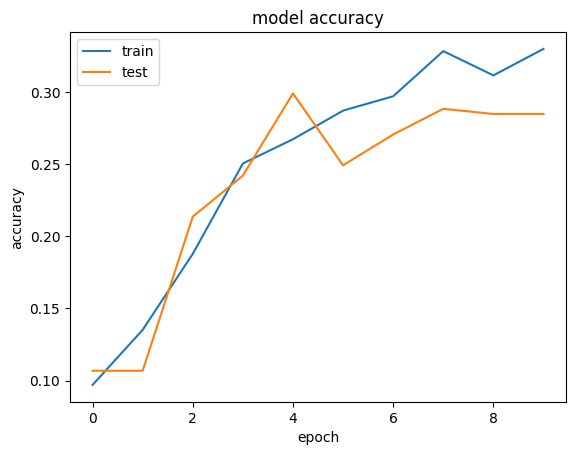

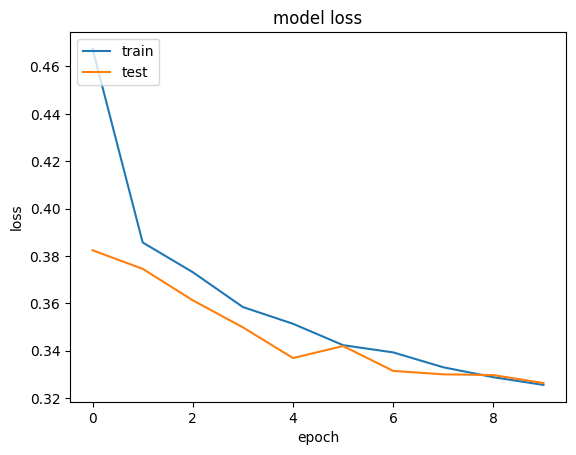

9/9 [==============================] - 0s 7ms/step
[[0.25300446 0.18509728 0.2150364  ... 0.0566994  0.10079202 0.25941956]
 [0.31415394 0.13703647 0.30561662 ... 0.06424411 0.11803192 0.1343659 ]
 [0.14697118 0.17542042 0.15958124 ... 0.06124559 0.06153055 0.07735067]
 ...
 [0.31506723 0.11947362 0.32065362 ... 0.08460167 0.09639494 0.13398032]
 [0.2294486  0.11238424 0.2424076  ... 0.0611261  0.07979003 0.19065762]
 [0.07903493 0.10763568 0.19475527 ... 0.10053109 0.10090652 0.09919077]]


When using 0.5 as threshold


aeroplane      1
bird           0
boat           0
chair          1
cow            0
diningtable    0
dog            0
horse          0
sheep          0
train          3
dtype: int64


/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


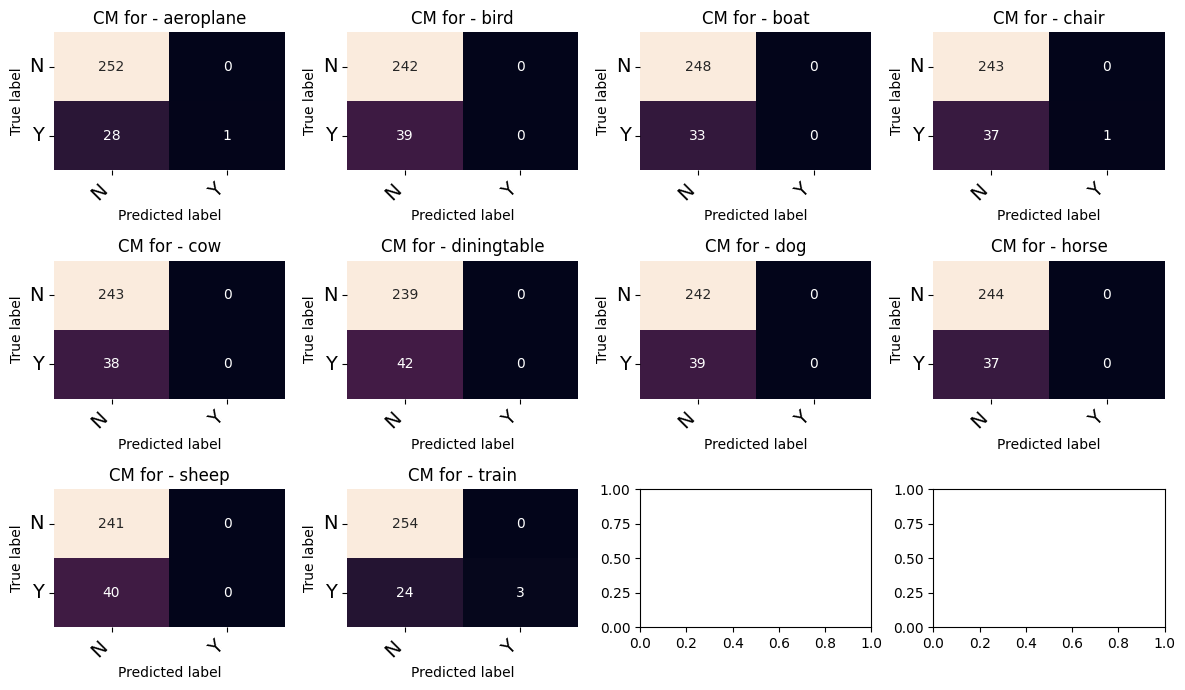



When using mean probability 0.11735549569129944 as threshold


aeroplane       62
bird           147
boat           169
chair          108
cow            106
diningtable     97
dog            148
horse          110
sheep           86
train          109
dtype: int64


/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


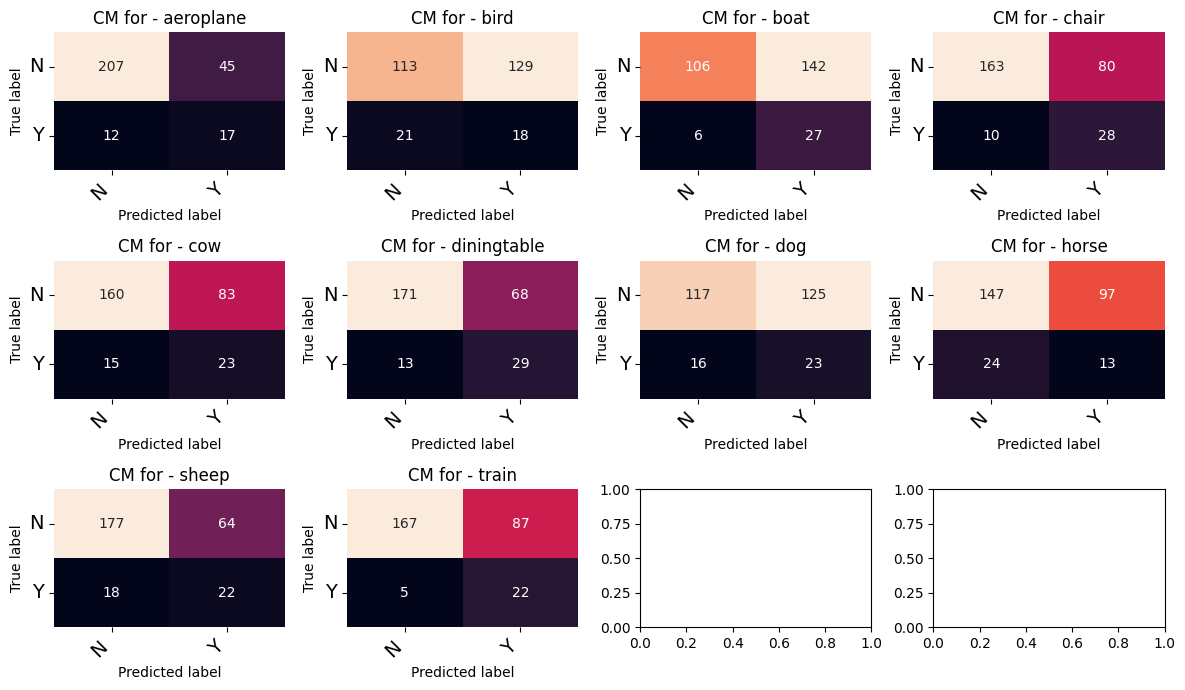



When using median probability 0.09929031878709793 as threshold


aeroplane       70
bird           182
boat           189
chair          121
cow            147
diningtable    111
dog            189
horse          139
sheep          123
train          134
dtype: int64


/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


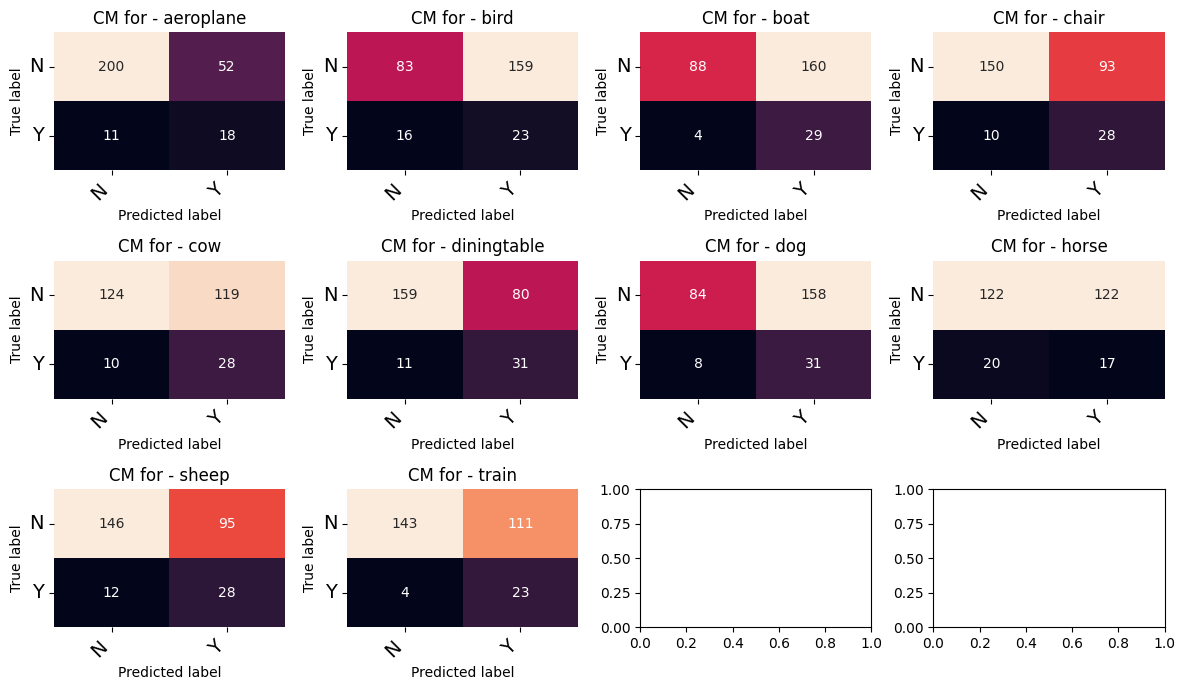

In [66]:
evaluate_model()

# Build and log VGG16 model on balanced data

In [13]:
def load_vgg16_model():
        
    model = VGG16(weights="imagenet", include_top=False, input_shape=(config.IM_SIZE, config.IM_SIZE, 3), classes=10)
        
    return model

def set_nontrainable_layers(model):
    
    # Set the first layers to be untrainable
    model.trainable = False
        
    return model

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(10, activation='sigmoid')
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model

In [71]:
def build_vgg16_model():

    model = load_vgg16_model()
    model = add_last_layers(model)
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])
    
    es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)
    
    vgg16_X_train = X_train
    vgg16_X_val = X_val
    vgg16_X_test = X_test

    vgg16_X_train = preproc_vgg16(vgg16_X_train) 
    vgg16_X_val = preproc_vgg16(vgg16_X_val)
    vgg16_X_test = preproc_vgg16(vgg16_X_test)
    
    history = model.fit(vgg16_X_train, y_train, 
                    validation_data=(vgg16_X_val, y_val), 
                    epochs=25, 
                    batch_size=32, 
                    callbacks=[es])
    model.save("../raw_data/models/final_vgg16")
    
#     res = model.evaluate(vgg16_X_test, y_test)
#     res
#     test_accuracy = res[-1]
#     print(f"test_accuracy = {round(test_accuracy,2)*100} %")
    
#     # summarize history for accuracy
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()
#     # summarize history for loss
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()
    
#     y_pred = model.predict(vgg16_X_test)
#     print(y_pred)
#     print("\n\nWhen using 0.5 as threshold\n\n")
#     classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
#     predictions = (y_pred > 0.5).astype("int32")
#     print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
#     predictions_df = pd.DataFrame(predictions)
#     predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
#     print(predictions_df.sum())
#     y_true = np.array(y_test)
#     mcm = multilabel_confusion_matrix(y_true, predictions) 
#     fig, ax = plt.subplots(3, 4, figsize=(12, 7))
#     for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
#         print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
#     fig.tight_layout()
#     plt.show()
    
#     print(f"\n\nWhen using mean probability {np.mean(y_pred)} as threshold\n\n")
#     predictions = (y_pred > np.mean(y_pred)).astype("int32")
#     print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
#     predictions_df = pd.DataFrame(predictions)
#     predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
#     print(predictions_df.sum())
#     y_true = np.array(y_test)
#     mcm = multilabel_confusion_matrix(y_true, predictions) 
#     fig, ax = plt.subplots(3, 4, figsize=(12, 7))
#     for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
#         print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
#     fig.tight_layout()
#     plt.show()
    
#     print(f"\n\nWhen using median probability {np.median(y_pred)} as threshold\n\n")
#     predictions = (y_pred > np.median(y_pred)).astype("int32")
#     print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
#     predictions_df = pd.DataFrame(predictions)
#     predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
#     print(predictions_df.sum())
#     y_true = np.array(y_test)
#     mcm = multilabel_confusion_matrix(y_true, predictions) 
#     fig, ax = plt.subplots(3, 4, figsize=(12, 7))
#     for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
#         print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
#     fig.tight_layout()
#     plt.show()
    return model, vgg16_X_test

In [14]:
def build_model(model, X_train, X_val, X_test):
    """This function will take a string input for the model to be built
    Args: pass in desired model as a string and X_train, X_val and X_test
        - baseline, vgg16, vgg19, resnet50, resnet152, resnet152v2, inceptionresnetv2, inceptionv3, xception
        - X_train, X_val, X_test
    Returns:
        Model loaded
        X_test preprocessed for testing
        History of accuracy and loss
    """
    model_name = str(model)

    if model == "baseline":
        model = load_baseline_model()
    if model == "vgg16":
        model = load_vgg16_model()
        model = add_last_layers(model)

        X_train = preproc_vgg16(X_train) 
        X_val = preproc_vgg16(X_val)
        X_test = preproc_vgg16(X_test)

    print(f'Model {model_name} loaded')
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])
    
    model.summary()

    es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)
    
    history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=25, 
                    batch_size=32, 
                    callbacks=[es])
    
    if os.path.exists(f"../raw_data/models/{model_name}/"):
        model.save(f"../raw_data/models/{model_name}")
    else:
        os.makedirs(f"../raw_data/models/{model_name}")
        print(f"The directory for {model_name} is created.")
  
    model.save(f"../raw_data/models/{model_name}")
    print("Model saved.")
    
    return model, model_name, X_test, history

In [15]:
print(y_train.shape)
print(y_val.shape)

(1313, 10)
(282, 10)


In [16]:
model, model_name, X_test, history = build_model("vgg16", X_train, X_val, X_test)

Model vgg16 loaded
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 500)               16384500  
                                                                 
 dense_1 (Dense)             (None, 10)                5010      
                                                                 
Total params: 31,104,198
Trainable params: 16,389,510
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/25


2022-09-26 20:35:32.832209: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-09-26 20:35:33.409969: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-09-26 20:35:33.410844: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-09-26 20:35:33.410861: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-09-26 20:35:33.410894: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 


 1/42 [..............................] - ETA: 2:59 - loss: 3.9504 - accuracy: 0.0938

2022-09-26 20:35:35.743608: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


42/42 [==============================] - 26s 522ms/step - loss: 1.1731 - accuracy: 0.3808 - val_loss: 0.6407 - val_accuracy: 0.4362
Epoch 2/25
42/42 [==============================] - 6s 134ms/step - loss: 0.0776 - accuracy: 0.8728 - val_loss: 0.7152 - val_accuracy: 0.4539
Epoch 3/25
42/42 [==============================] - 6s 148ms/step - loss: 0.0083 - accuracy: 0.8835 - val_loss: 0.7217 - val_accuracy: 0.4894
Epoch 4/25
42/42 [==============================] - 6s 136ms/step - loss: 0.0016 - accuracy: 0.8949 - val_loss: 0.7282 - val_accuracy: 0.4929
Epoch 5/25
42/42 [==============================] - 6s 139ms/step - loss: 8.2569e-04 - accuracy: 0.8957 - val_loss: 0.7505 - val_accuracy: 0.4752
Epoch 6/25
42/42 [==============================] - 6s 135ms/step - loss: 6.0799e-04 - accuracy: 0.8919 - val_loss: 0.7594 - val_accuracy: 0.4858
Epoch 7/25
42/42 [==============================] - 5s 131ms/step - loss: 4.9007e-04 - accuracy: 0.8911 - val_loss: 0.7669 - val_accuracy: 0.4858
Epoc

INFO:tensorflow:Assets written to: ../raw_data/models/vgg16/assets


INFO:tensorflow:Assets written to: ../raw_data/models/vgg16/assets


Model saved.


In [20]:
print(type(model))
print(type(model_name))
print(type(X_test))
print(type(history))

<class 'keras.engine.sequential.Sequential'>
<class 'str'>
<class 'numpy.ndarray'>
<class 'keras.callbacks.History'>


In [30]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("CM for - " + class_label)
    
def evaluate(model, model_name, test):
    res = model.evaluate(test, y_test)
    res
    test_accuracy = res[-1]
    print(f"test_accuracy = {round(test_accuracy,2)*100} %")
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('../raw_data/models/' + str(model_name) + '/' + 'accuracy.png')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('../raw_data/models/' + str(model_name) + '/' + 'loss.png')
    plt.show()
    y_pred = model.predict(test)

    return model, y_pred

9/9 [==============================] - 1s 104ms/step - loss: 0.6771 - accuracy: 0.4911
test_accuracy = 49.0 %
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


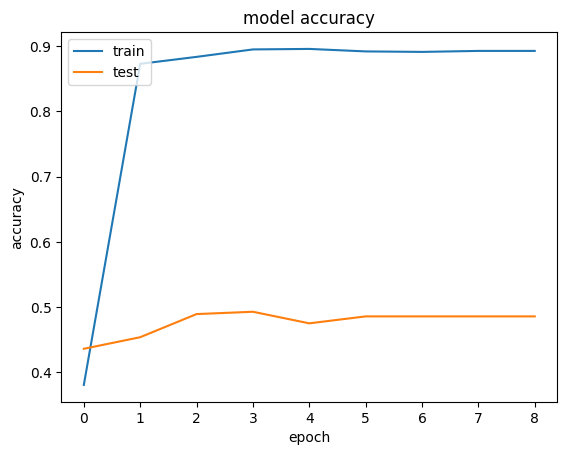

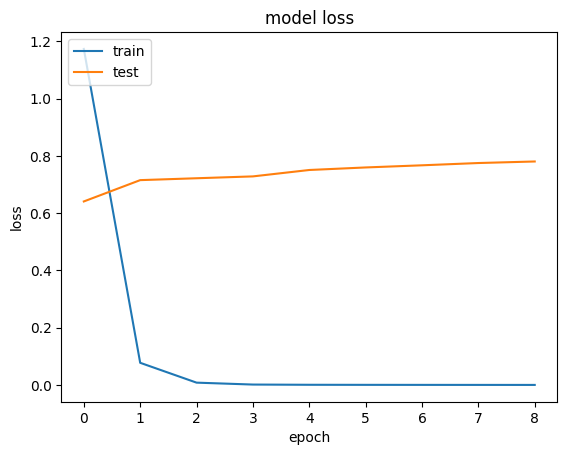

9/9 [==============================] - 1s 106ms/step


In [32]:
model, y_pred = evaluate(model, model_name, X_test)

In [38]:
def generate_reports(model, model_name, y_pred):
    thresholds = [0.5, np.mean(y_pred), np.median(y_pred)]
    for i in thresholds:       
        print(f"\n\nWhen using {i} as threshold\n\n")
        predictions = y_pred > i
        report = classification_report(y_test, predictions, output_dict=True, target_names=config.CLASSES)
        classification_df = pd.DataFrame(list(report.items()),columns = ['class','scores']) 
        classification_df.to_csv(f"../raw_data/models/{model_name}/classification_report_{i}.csv")
        predictions_df = pd.DataFrame(predictions)
        predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
        print(predictions_df.sum())
        y_true = np.array(y_test)
        mcm = multilabel_confusion_matrix(y_true, predictions) 
        fig, ax = plt.subplots(3, 4, figsize=(12, 7))
        for axes, cfs_matrix, label in zip(ax.flatten(), mcm, config.CLASSES):
            print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
        fig.tight_layout()
        plt.savefig(f'../raw_data/models/{model_name}/confusion_matrix_{i}.png')
        plt.show()




When using 0.5 as threshold


aeroplane      18
bird           12
boat           29
chair          40
cow            20
diningtable    21
dog            17
horse          25
sheep          23
train          23
dtype: int64


/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


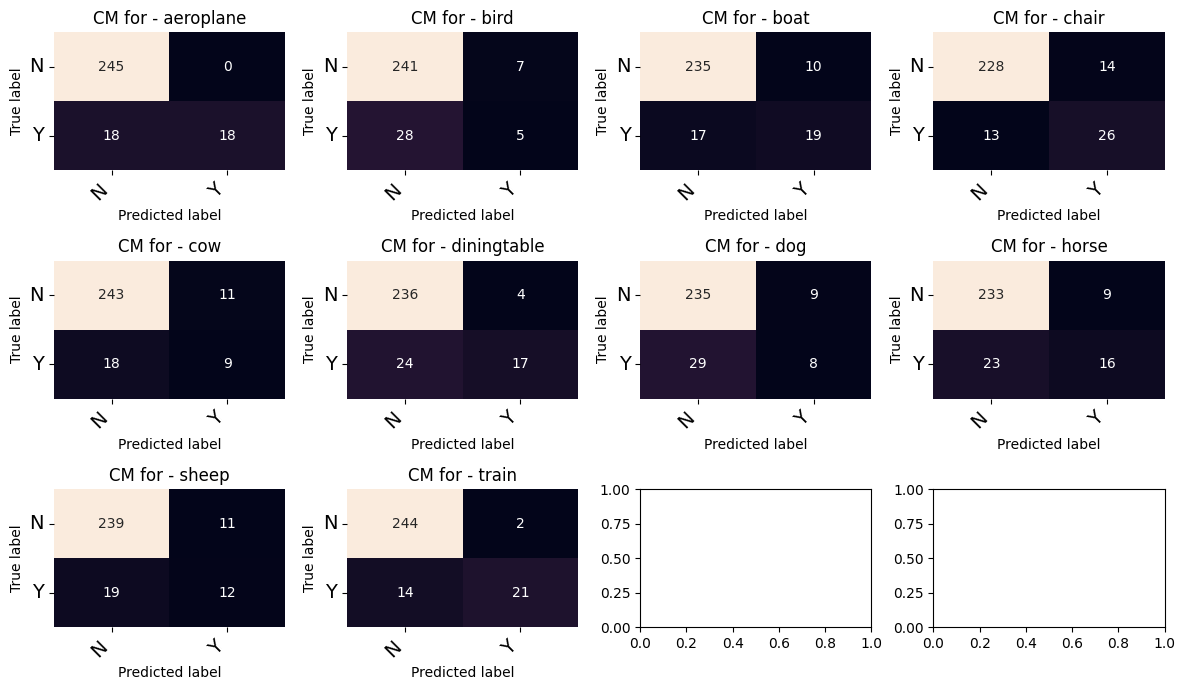



When using 0.08454354107379913 as threshold


aeroplane      25
bird           22
boat           40
chair          53
cow            36
diningtable    32
dog            36
horse          41
sheep          34
train          29
dtype: int64


/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


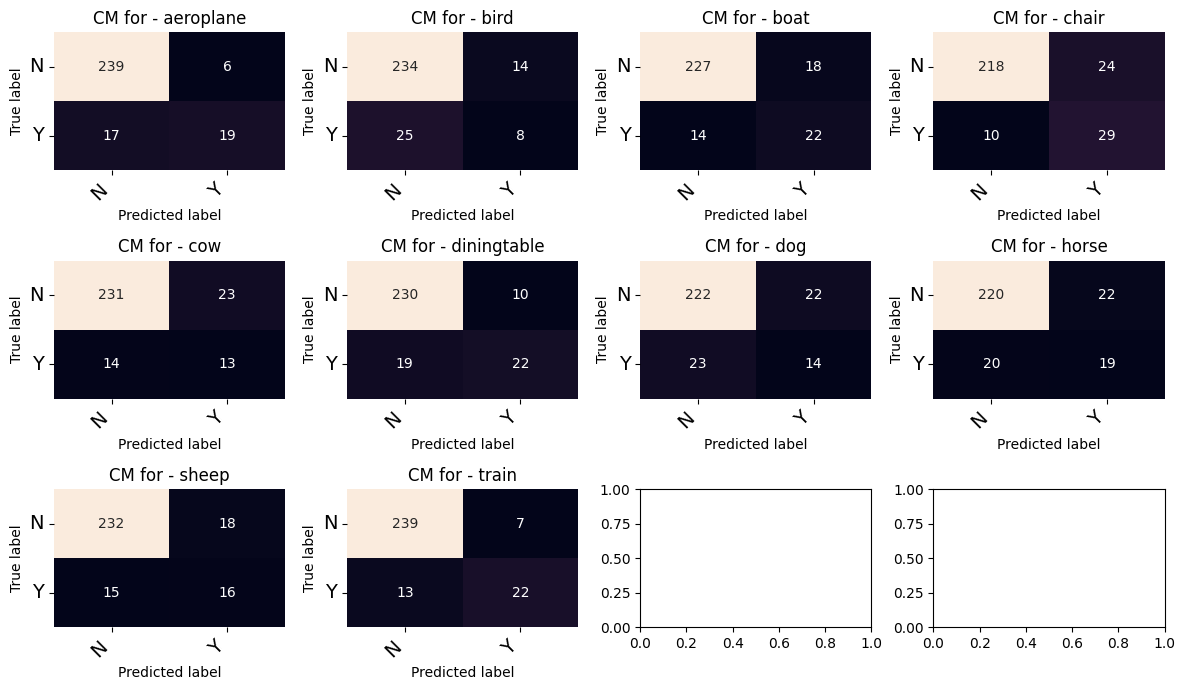



When using 3.382396926099318e-06 as threshold


aeroplane      101
bird           182
boat           134
chair          128
cow            131
diningtable    131
dog            180
horse          161
sheep          112
train          145
dtype: int64


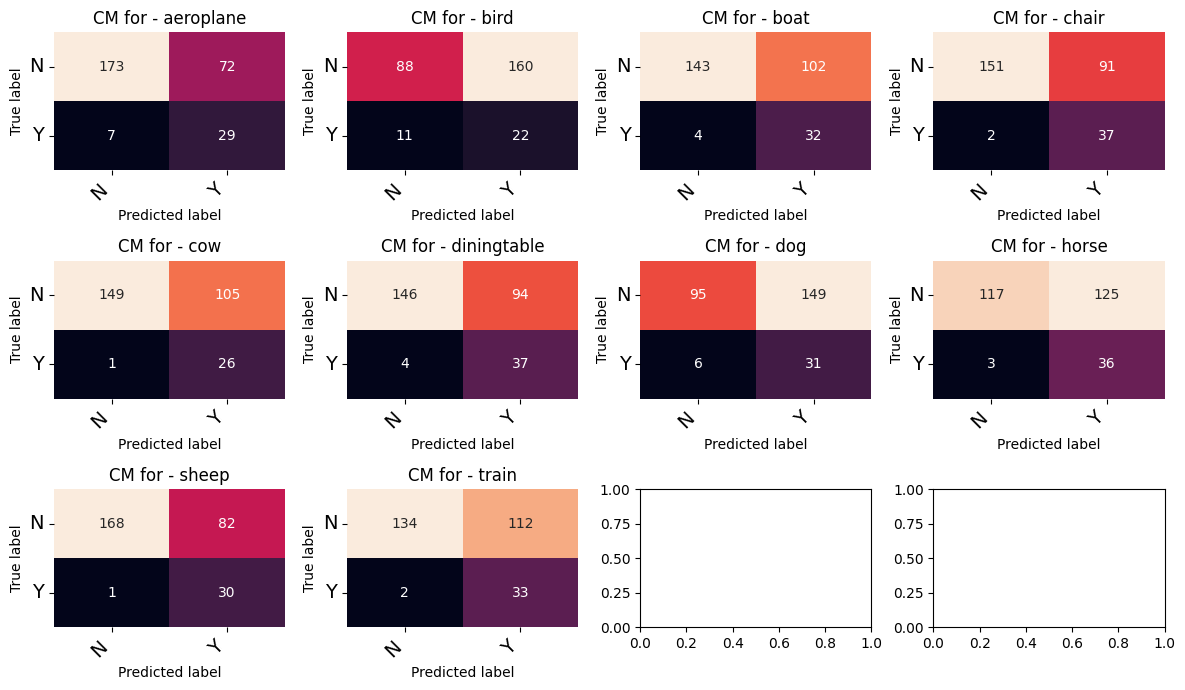

In [39]:
generate_reports(model, model_name, y_pred)

In [79]:
def test_eval(model, test, model_name, test_name):
    res = model.evaluate(test, y_test)
    res
    test_accuracy = res[-1]
    print(f"test_accuracy = {round(test_accuracy,2)*100} %")
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('../raw_data/models/' + str(model_name) + '/' + str(test_name) + '.png')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('../raw_data/models/final_baseline/baseline_loss.png')
    plt.show()

    y_pred = model.predict(test)
    print(y_pred)
    print("\n\nWhen using 0.5 as threshold\n\n")
    classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
    predictions = (y_pred > 0.5).astype("int32")
    report = classification_report(y_test, predictions, output_dict=True, target_names=classes)
    classification_df = pd.DataFrame(list(report.items()),columns = ['class','scores']) 
    #classification_df.to_csv("../raw_data/models/final_baseline/classificationreport0.5.csv")
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    #plt.savefig('../raw_data/models/final_baseline/baseline_cm0.5.png')
    plt.show()
    
    print(f"\n\nWhen using mean probability {np.mean(y_pred)} as threshold\n\n")
    classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
    predictions = (y_pred > np.mean(y_pred)).astype("int32")
    report = classification_report(y_test, predictions, output_dict=True, target_names=classes)
    classification_df = pd.DataFrame(list(report.items()),columns = ['class','scores']) 
    #classification_df.to_csv("../raw_data/models/final_baseline/classificationreportmean.csv")
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    #plt.savefig('../raw_data/models/final_baseline/baseline_cmmean.png')
    plt.show()
    
    print(f"\n\nWhen using median probability {np.median(y_pred)} as threshold\n\n")
    classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
    predictions = (y_pred > np.median(y_pred)).astype("int32")
    report = classification_report(y_test, predictions, output_dict=True, target_names=classes)
    classification_df = pd.DataFrame(list(report.items()),columns = ['class','scores']) 
    classification_df.to_csv("../raw_data/models/final_baseline/classificationreportmedian.csv")
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    #plt.savefig('../raw_data/models/final_baseline/baseline_cmmedian.png')
    plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 500)               16384500  
                                                                 
 dense_3 (Dense)             (None, 10)                5010      
                                                                 
Total params: 31,104,198
Trainable params: 16,389,510
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/25
42/42 [==============================] - 8s 150ms/step - loss: 1.1234 - accuracy: 0.4015 - val_loss: 0.6534 - val_accuracy: 0.4894
Epoch 2/25
42/42 [=====

INFO:tensorflow:Assets written to: ../raw_data/models/final_vgg16/assets


INFO:tensorflow:Assets written to: ../raw_data/models/final_vgg16/assets


9/9 [==============================] - 1s 88ms/step - loss: 0.7535 - accuracy: 0.4787
test_accuracy = 48.0 %


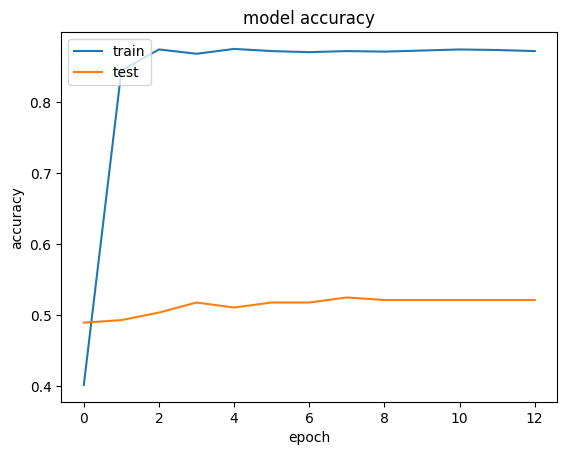

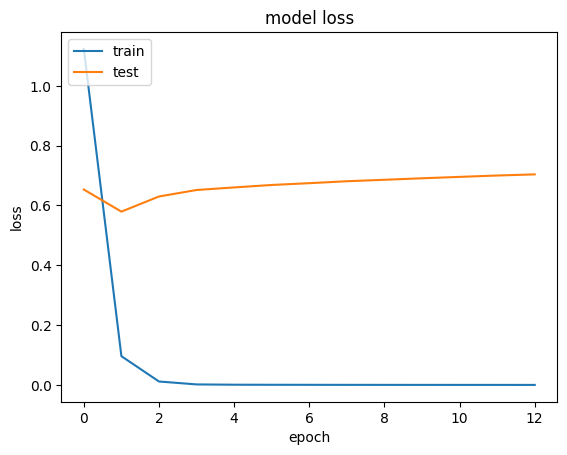

9/9 [==============================] - 1s 88ms/step
[[1.0066782e-03 1.5776242e-05 6.8493551e-03 ... 6.1190212e-01
  1.5914522e-02 4.3228015e-06]
 [4.2543941e-11 2.1969521e-08 3.4187672e-12 ... 2.4962418e-07
  9.3983127e-11 3.1195488e-10]
 [7.9266471e-08 8.1935353e-12 6.5923581e-05 ... 1.1920630e-12
  3.6902920e-12 1.0000000e+00]
 ...
 [2.9840642e-08 3.7307848e-10 5.0202115e-03 ... 9.9521375e-01
  3.2282348e-06 8.6291640e-11]
 [2.0702225e-06 3.6850800e-08 2.1162827e-02 ... 1.2576647e-04
  8.4180489e-02 6.6753146e-06]
 [4.2219124e-08 5.0433201e-08 3.3399090e-01 ... 2.1365726e-05
  2.0687957e-03 2.9904095e-07]]


When using 0.5 as threshold


              precision    recall  f1-score   support

   aeroplane       0.93      0.46      0.62        28
        bird       0.33      0.02      0.04        43
        boat       0.75      0.45      0.56        40
       chair       0.71      0.55      0.62        31
         cow       0.69      0.58      0.63        31
 diningtable       0.84    

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


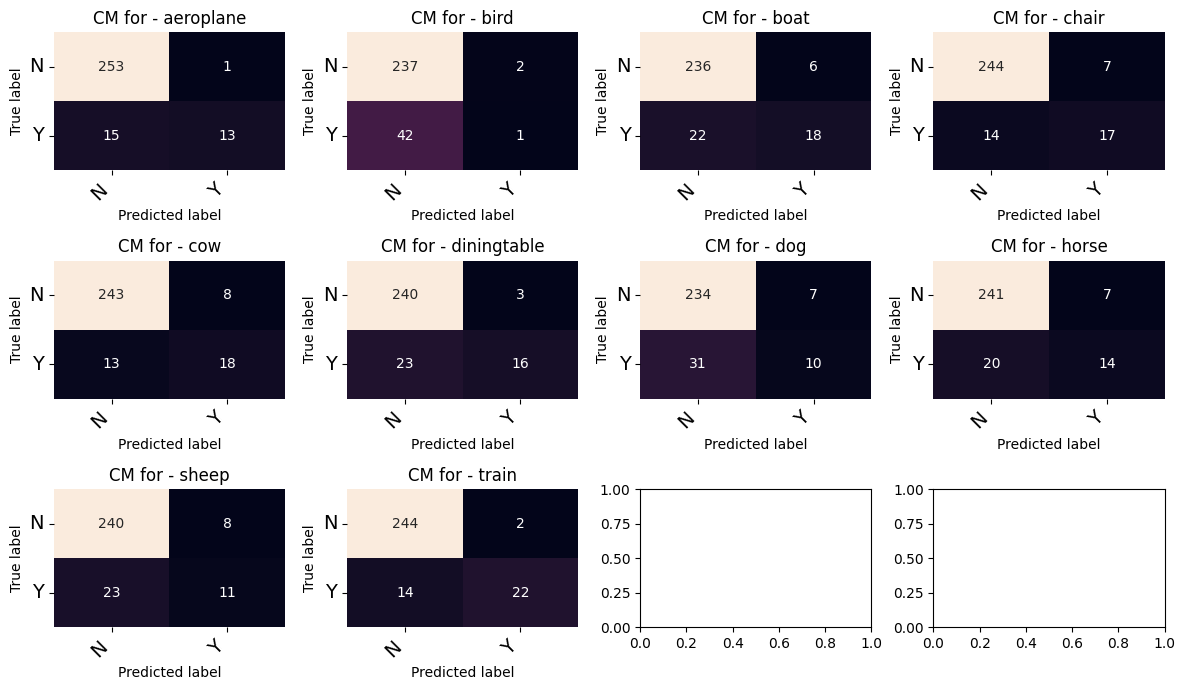



When using mean probability 0.07236098498106003 as threshold


              precision    recall  f1-score   support

   aeroplane       0.83      0.54      0.65        28
        bird       0.33      0.07      0.12        43
        boat       0.66      0.57      0.61        40
       chair       0.56      0.58      0.57        31
         cow       0.53      0.65      0.58        31
 diningtable       0.68      0.59      0.63        39
         dog       0.42      0.37      0.39        41
       horse       0.51      0.53      0.52        34
       sheep       0.50      0.41      0.45        34
       train       0.77      0.67      0.72        36

   micro avg       0.58      0.48      0.53       357
   macro avg       0.58      0.50      0.52       357
weighted avg       0.57      0.48      0.51       357
 samples avg       0.47      0.51      0.47       357

aeroplane      18
bird            9
boat           35
chair          32
cow            38
diningtable    34
dog           

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


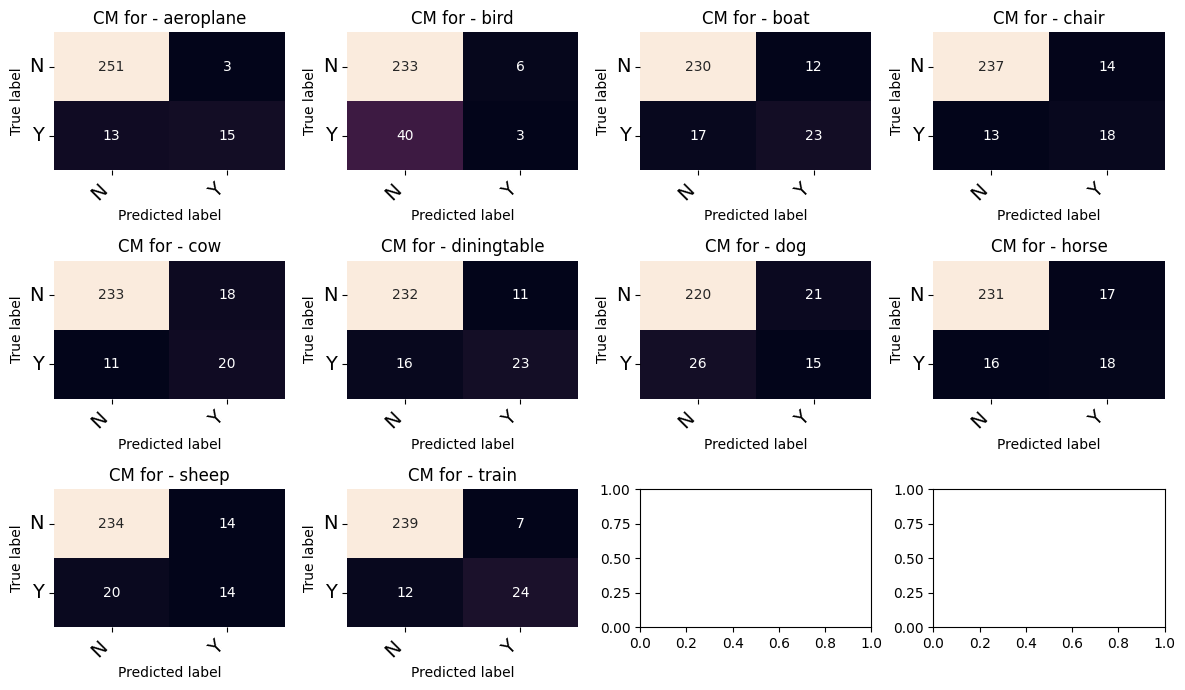



When using median probability 1.5866252169871586e-06 as threshold


              precision    recall  f1-score   support

   aeroplane       0.22      0.93      0.36        28
        bird       0.18      0.70      0.29        43
        boat       0.27      0.93      0.42        40
       chair       0.25      0.97      0.40        31
         cow       0.19      0.94      0.32        31
 diningtable       0.28      0.95      0.44        39
         dog       0.20      0.90      0.33        41
       horse       0.19      0.94      0.32        34
       sheep       0.20      0.76      0.32        34
       train       0.27      0.86      0.41        36

   micro avg       0.22      0.88      0.36       357
   macro avg       0.23      0.89      0.36       357
weighted avg       0.23      0.88      0.36       357
 samples avg       0.30      0.91      0.41       357

aeroplane      118
bird           165
boat           137
chair          120
cow            149
diningtable    131
dog

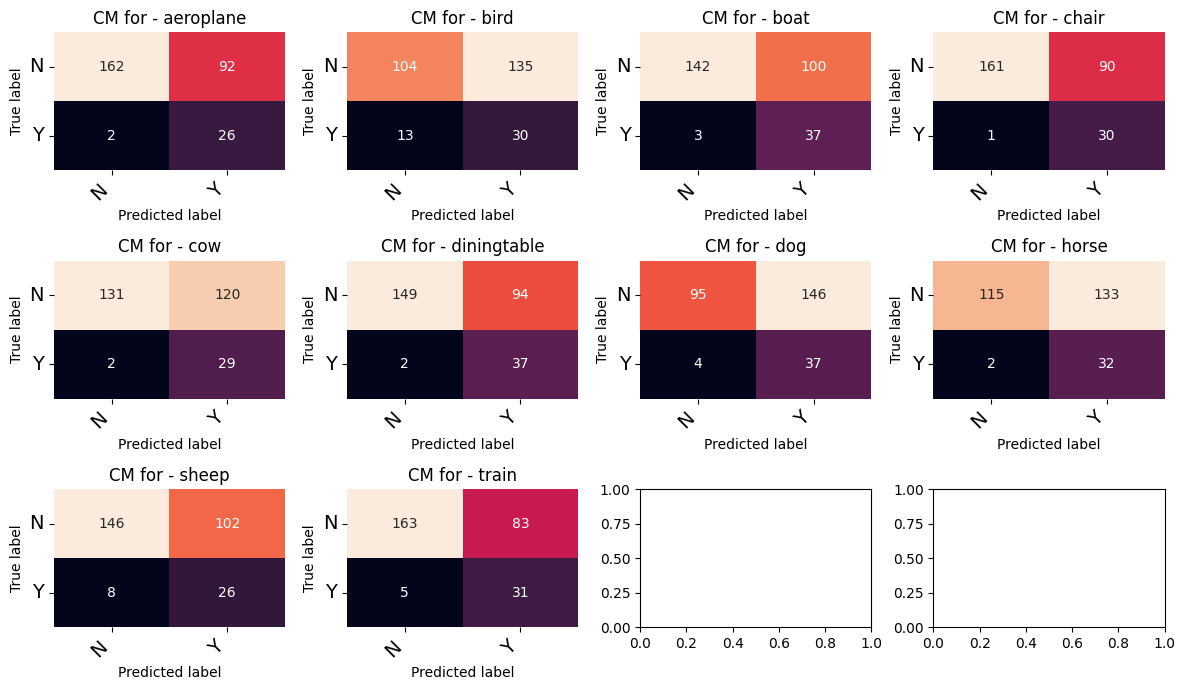

In [19]:
vgg16 = build_vgg16_model()

9/9 [==============================] - 1s 83ms/step - loss: 0.7097 - accuracy: 0.4484
test_accuracy = 45.0 %
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


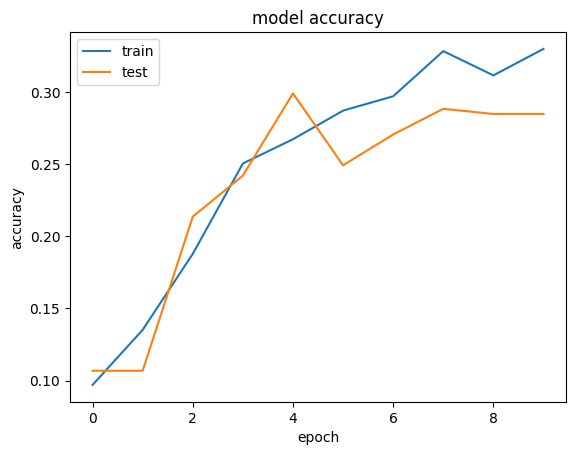

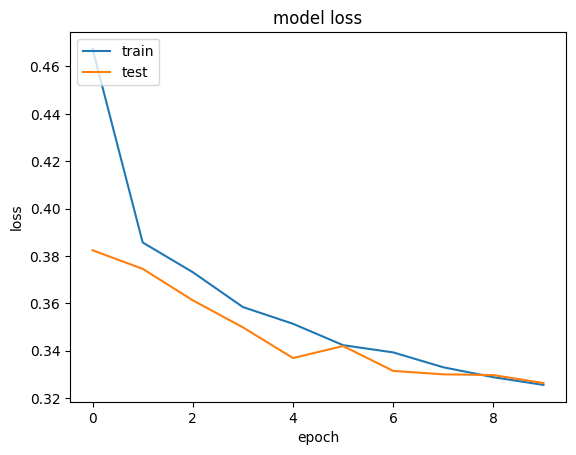

9/9 [==============================] - 1s 85ms/step
[[3.56490761e-01 2.39658612e-03 7.56307645e-03 ... 1.67157632e-05
  1.08168269e-05 2.79672019e-09]
 [9.21554744e-01 1.16644125e-03 8.12428165e-03 ... 3.51198432e-05
  6.84141356e-04 1.61539418e-07]
 [8.82567441e-09 2.00598879e-06 5.71566936e-08 ... 5.97917102e-03
  1.61369428e-07 8.04596766e-06]
 ...
 [9.77628224e-06 1.35271985e-03 3.35100514e-04 ... 2.88657304e-07
  5.37761625e-05 4.34042171e-08]
 [4.55114208e-02 1.97696252e-07 5.06066407e-08 ... 1.06767885e-07
  5.39553506e-11 2.06805766e-02]
 [8.09693873e-01 9.14447955e-05 3.30820127e-09 ... 7.93025734e-09
  3.20904476e-08 8.76554113e-05]]


When using 0.5 as threshold


aeroplane      18
bird            4
boat           17
chair          30
cow            16
diningtable    30
dog            19
horse          19
sheep          22
train          23
dtype: int64


/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


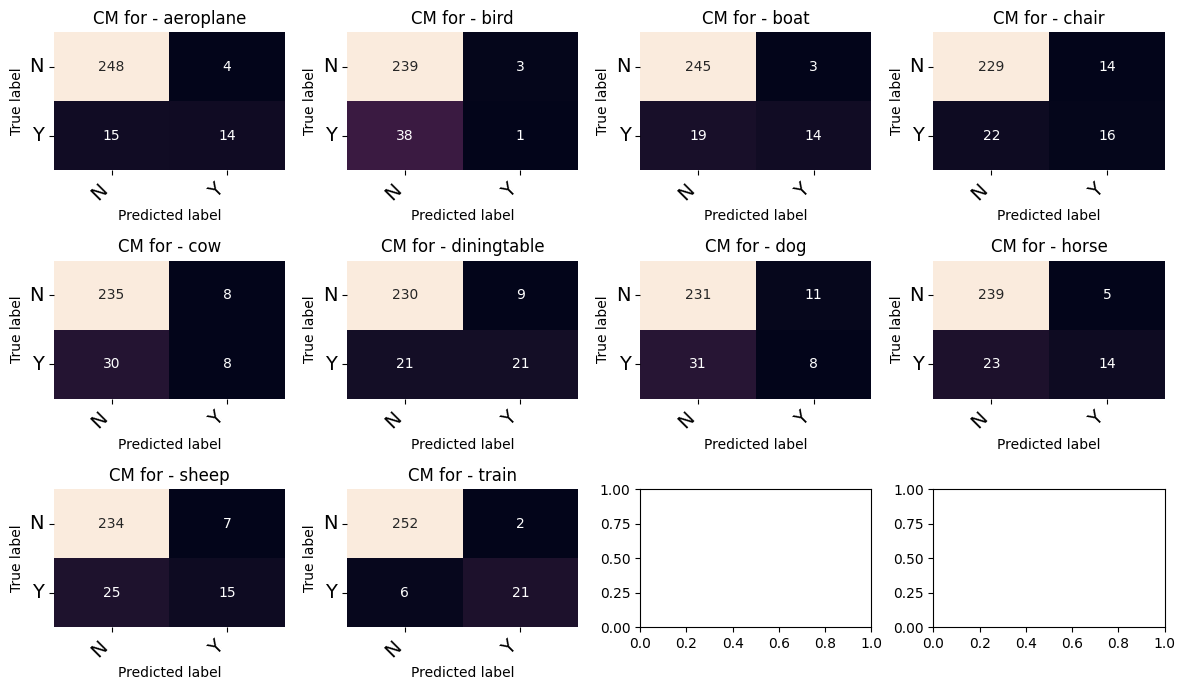



When using mean probability 0.07553598284721375 as threshold


aeroplane      23
bird           10
boat           28
chair          41
cow            34
diningtable    41
dog            38
horse          38
sheep          37
train          28
dtype: int64


/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


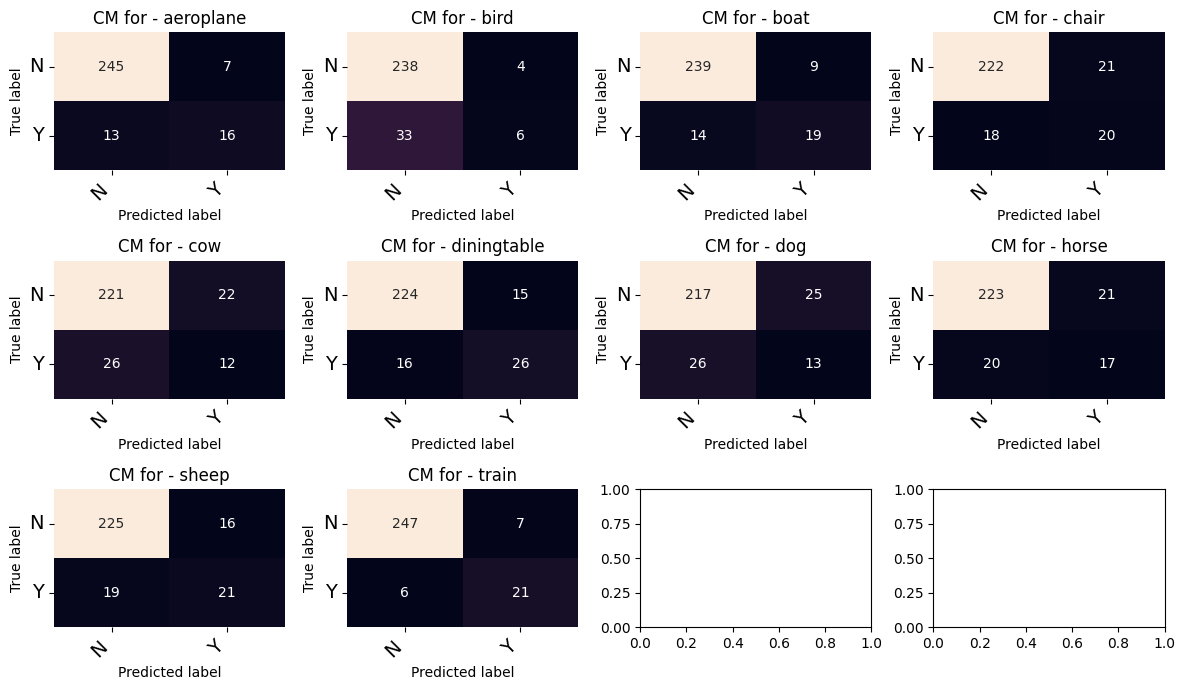



When using median probability 6.094576292525744e-06 as threshold


aeroplane      122
bird           159
boat           141
chair          117
cow            154
diningtable    153
dog            175
horse          148
sheep          118
train          118
dtype: int64


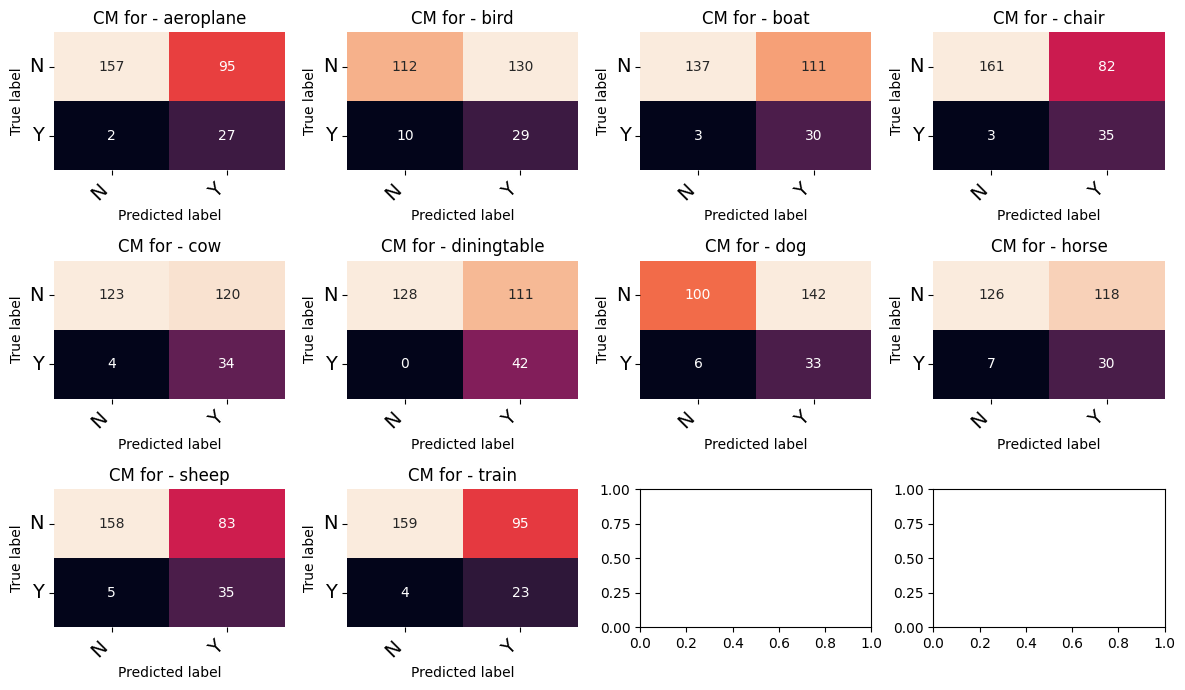

In [80]:
test_eval(vgg16_model, vgg16_X_test, "vgg16_model", "vgg16_X_test")

In [28]:
y_pred = model.predict(X_test)
print(y_pred)
print(type(y_pred[0]))
classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
thresholds = [0.5, np.mean(y_pred), np.median(y_pred)]

9/9 [==============================] - 0s 32ms/step
[[0.00673691 0.09745266 0.00501083 ... 0.09044058 0.02701222 0.07995526]
 [0.05042534 0.06656671 0.2781276  ... 0.18354046 0.18371214 0.02625021]
 [0.00471445 0.04647163 0.04151465 ... 0.27078053 0.18591253 0.01884601]
 ...
 [0.45419964 0.07074612 0.19669215 ... 0.03052393 0.05317817 0.00699287]
 [0.05268376 0.06493931 0.09246758 ... 0.10126639 0.05782941 0.01029165]
 [0.00674291 0.08078088 0.02463096 ... 0.08015896 0.03136269 0.11374255]]
<class 'numpy.ndarray'>


In [29]:
for i in thresholds:
    print(type(i))

<class 'float'>
<class 'numpy.float32'>
<class 'numpy.float32'>


In [43]:
def generate_reports(model, classification_report_filename, confusion_matrix_filename):
    for i in thresholds:       
        print(f"\n\nWhen using {i} as threshold\n\n")
        predictions = y_pred > i
        report = classification_report(y_test, predictions, output_dict=True, target_names=classes)
        classification_df = pd.DataFrame(list(report.items()),columns = ['class','scores']) 
        classification_df.to_csv(f"../raw_data/models/{model}/{classification_report_filename}_{i}")
        predictions_df = pd.DataFrame(predictions)
        predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
        print(predictions_df.sum())
        y_true = np.array(y_test)
        mcm = multilabel_confusion_matrix(y_true, predictions) 
        fig, ax = plt.subplots(3, 4, figsize=(12, 7))
        for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
            print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
        fig.tight_layout()
        plt.savefig(f'../raw_data/models/{model}/{confusion_matrix_filename}_{i}.png')
        plt.show()



When using 0.5 as threshold


aeroplane       2
bird            0
boat            1
chair          18
cow             1
diningtable     5
dog             0
horse           0
sheep           1
train          10
dtype: int64


/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


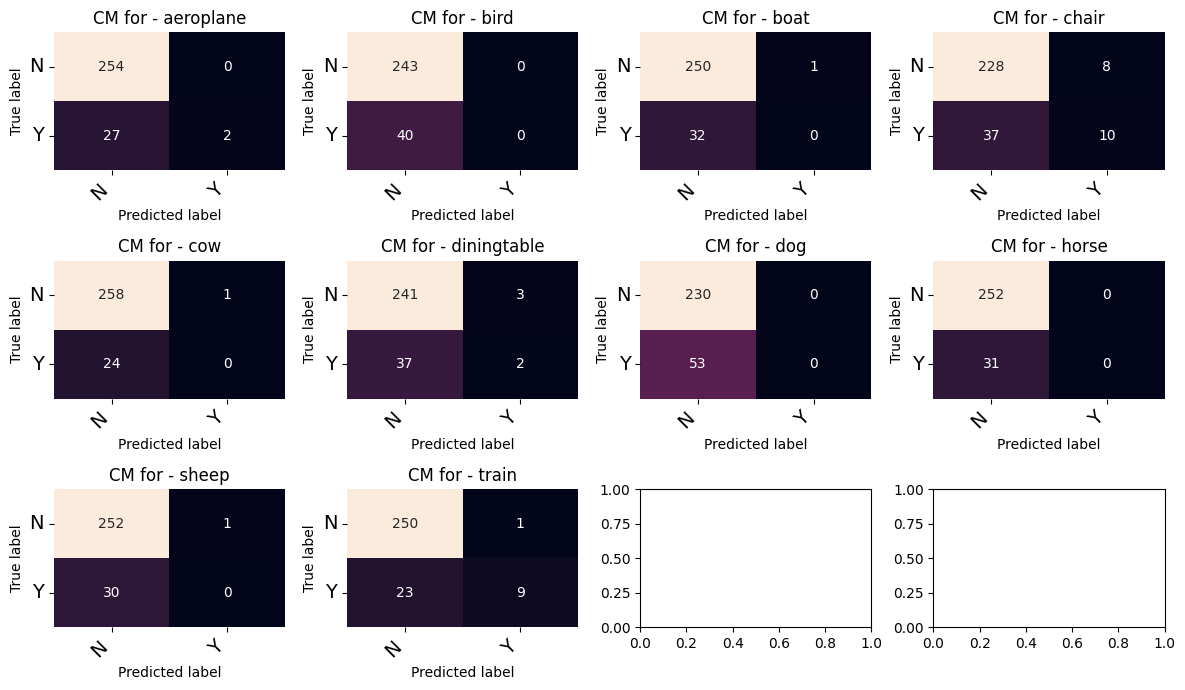



When using 0.11201009899377823 as threshold


aeroplane       35
bird            35
boat            85
chair          122
cow             68
diningtable    135
dog            240
horse          160
sheep          121
train           47
dtype: int64


/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


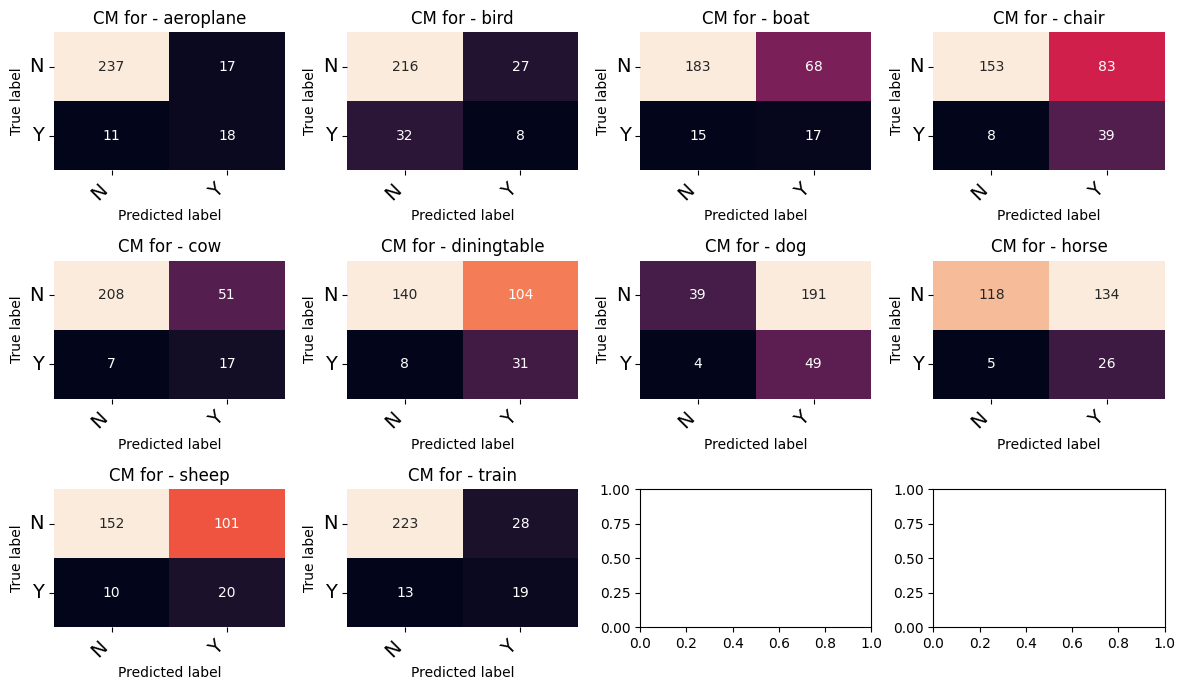



When using 0.07251280546188354 as threshold


aeroplane       47
bird           104
boat           120
chair          153
cow            114
diningtable    163
dog            271
horse          206
sheep          163
train           74
dtype: int64


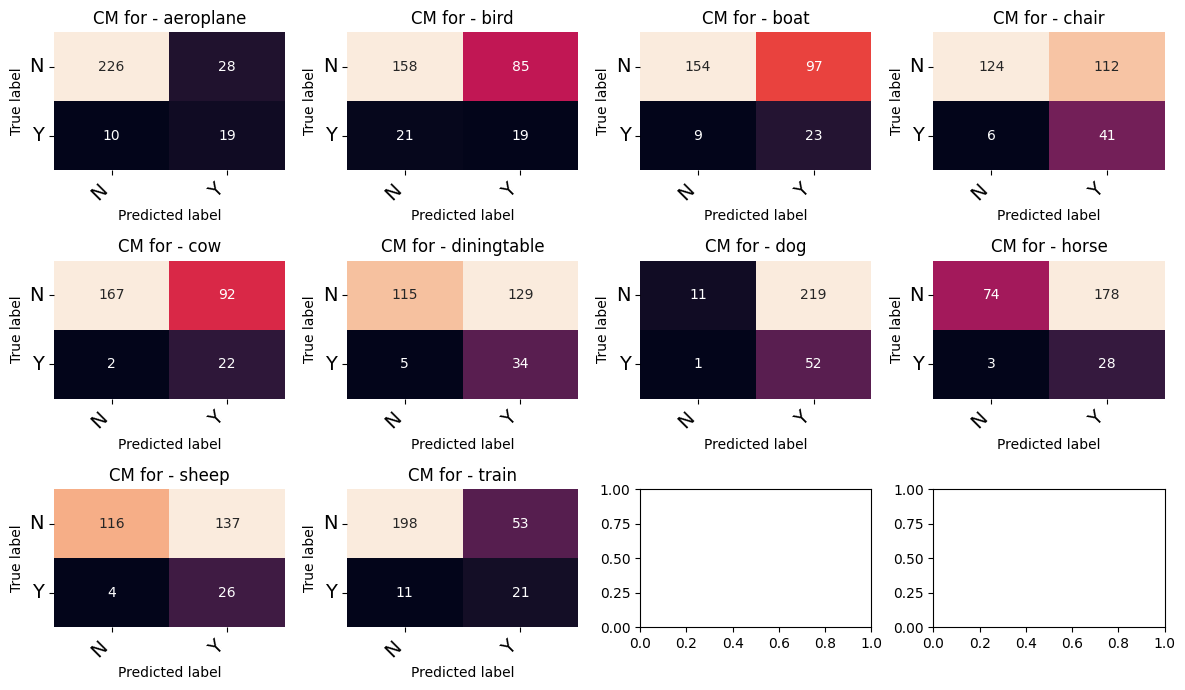

In [44]:
generate_reports("final_baseline", "classification_report", "confusion_matrix")

# Build and log VGG19 model on balanced data

In [20]:
def load_vgg19_model():
        
    model = VGG19(weights="imagenet", include_top=False, input_shape=(config.IM_SIZE, config.IM_SIZE, 3), classes=10)
        
    return model

In [21]:
def build_vgg19_model():

    model = load_vgg19_model()
    model = add_last_layers(model)
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])
    
    es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)
    
    vgg19_X_train = X_train
    vgg19_X_val = X_val
    vgg19_X_test = X_test

    vgg19_X_train = preproc_vgg19(vgg19_X_train) 
    vgg19_X_val = preproc_vgg19(vgg19_X_val)
    vgg19_X_test = preproc_vgg19(vgg19_X_test)
    
    history = model.fit(vgg19_X_train, y_train, 
                    validation_data=(vgg19_X_val, y_val), 
                    epochs=25, 
                    batch_size=32, 
                    callbacks=[es])
    model.save("../raw_data/models/final_vgg19")
    res = model.evaluate(vgg19_X_test, y_test)
    res
    test_accuracy = res[-1]
    print(f"test_accuracy = {round(test_accuracy,2)*100} %")
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    y_pred = model.predict(vgg19_X_test)
    print(y_pred)
    print("\n\nWhen using 0.5 as threshold\n\n")
    classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
    predictions = (y_pred > 0.5).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using mean probability {np.mean(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.mean(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using median probability {np.median(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.median(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 500)               16384500  
                                                                 
 dense_5 (Dense)             (None, 10)                5010      
                                                                 
Total params: 36,413,894
Trainable params: 16,389,510
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/25
42/42 [==============================] - 6s 137ms/step - loss: 1.1075 - accuracy: 0.3909 - val_loss: 0.6103 - val_accuracy: 0.5177
Epoch 2/25
42/42 [=====

INFO:tensorflow:Assets written to: ../raw_data/models/final_vgg19/assets


INFO:tensorflow:Assets written to: ../raw_data/models/final_vgg19/assets


9/9 [==============================] - 1s 104ms/step - loss: 0.7501 - accuracy: 0.5071
test_accuracy = 51.0 %


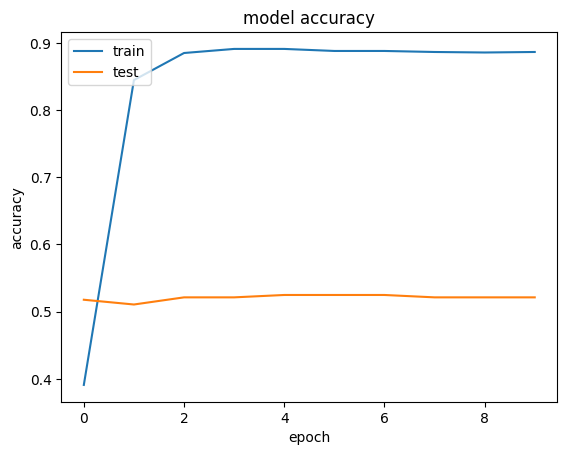

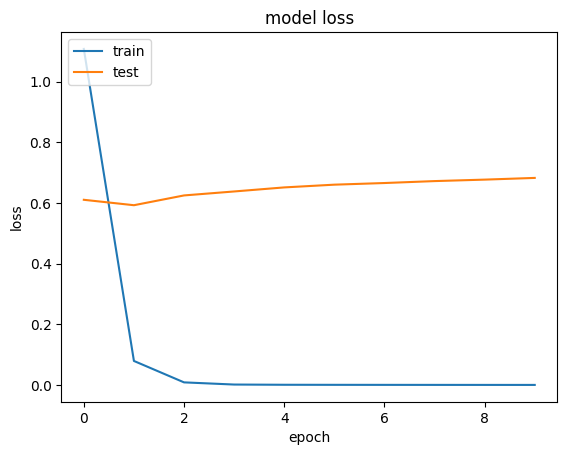

9/9 [==============================] - 1s 101ms/step
[[1.9021396e-06 1.2702951e-05 3.0554731e-06 ... 9.2110075e-02
  5.2297514e-02 2.4190017e-03]
 [7.0008662e-14 2.0243005e-09 6.5263414e-08 ... 1.3514436e-05
  1.2066554e-12 2.5331222e-08]
 [4.6217921e-01 1.2406822e-05 2.4452945e-14 ... 3.6188736e-16
  1.3580413e-19 1.0000000e+00]
 ...
 [7.6609741e-10 9.9993343e-08 2.8779454e-09 ... 9.9904102e-01
  1.1364970e-11 6.9874594e-14]
 [3.1534382e-03 6.3360803e-04 5.6261368e-05 ... 1.6458427e-03
  2.5120012e-03 4.0896467e-07]
 [3.1799496e-09 1.3219064e-09 3.3348662e-01 ... 1.0943552e-09
  3.8975464e-05 2.8505170e-08]]


When using 0.5 as threshold


              precision    recall  f1-score   support

   aeroplane       0.86      0.43      0.57        28
        bird       0.50      0.14      0.22        43
        boat       0.83      0.50      0.62        40
       chair       0.69      0.58      0.63        31
         cow       0.62      0.52      0.56        31
 diningtable       0.82   

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


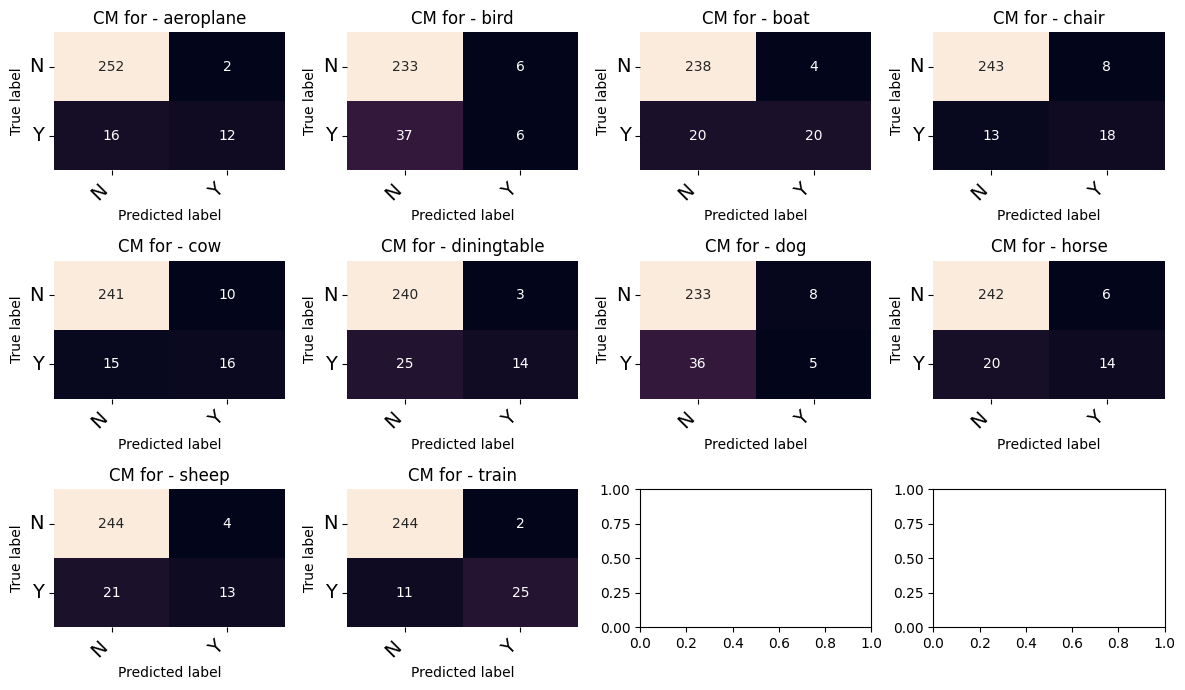



When using mean probability 0.07286248356103897 as threshold


              precision    recall  f1-score   support

   aeroplane       0.62      0.54      0.58        28
        bird       0.30      0.16      0.21        43
        boat       0.69      0.68      0.68        40
       chair       0.59      0.65      0.62        31
         cow       0.47      0.58      0.52        31
 diningtable       0.64      0.46      0.54        39
         dog       0.30      0.20      0.24        41
       horse       0.56      0.53      0.55        34
       sheep       0.62      0.53      0.57        34
       train       0.89      0.69      0.78        36

   micro avg       0.58      0.49      0.53       357
   macro avg       0.57      0.50      0.53       357
weighted avg       0.56      0.49      0.52       357
 samples avg       0.50      0.53      0.49       357

aeroplane      24
bird           23
boat           39
chair          34
cow            38
diningtable    28
dog           

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


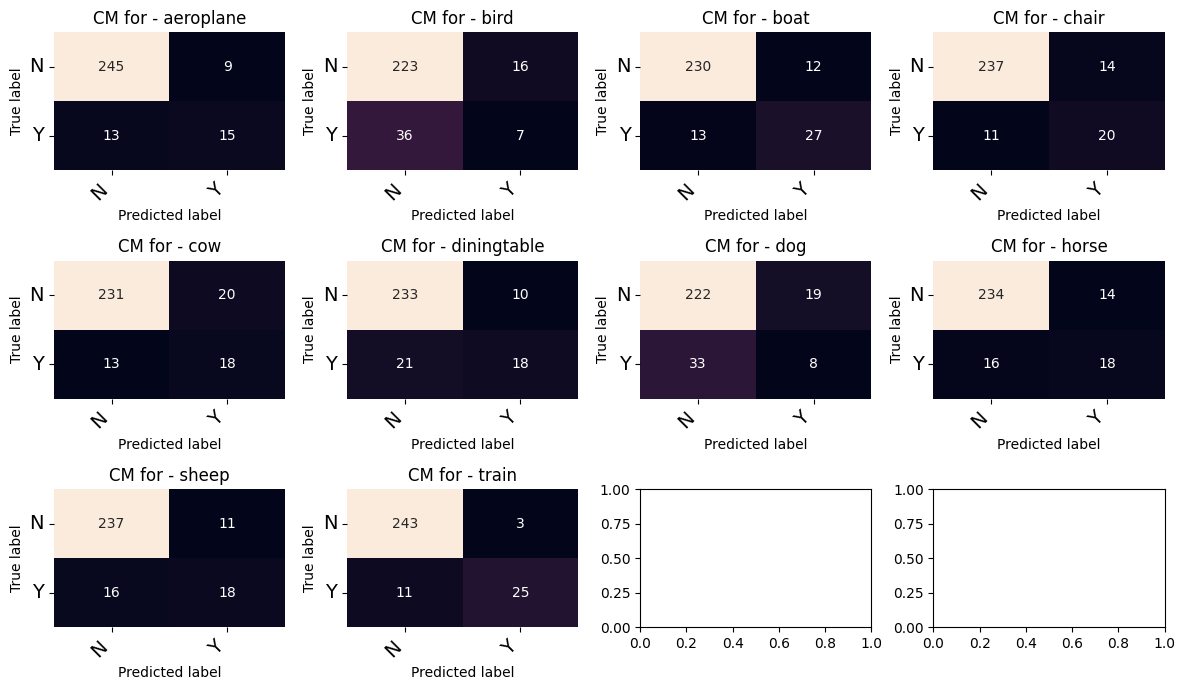



When using median probability 3.1849256174609764e-06 as threshold


              precision    recall  f1-score   support

   aeroplane       0.22      1.00      0.36        28
        bird       0.18      0.67      0.29        43
        boat       0.24      0.88      0.38        40
       chair       0.21      0.97      0.35        31
         cow       0.19      0.87      0.32        31
 diningtable       0.23      0.82      0.36        39
         dog       0.22      0.85      0.35        41
       horse       0.20      0.91      0.32        34
       sheep       0.24      0.85      0.37        34
       train       0.24      0.86      0.38        36

   micro avg       0.22      0.86      0.35       357
   macro avg       0.22      0.87      0.35       357
weighted avg       0.22      0.86      0.35       357
 samples avg       0.30      0.89      0.40       357

aeroplane      127
bird           158
boat           143
chair          140
cow            140
diningtable    138
dog

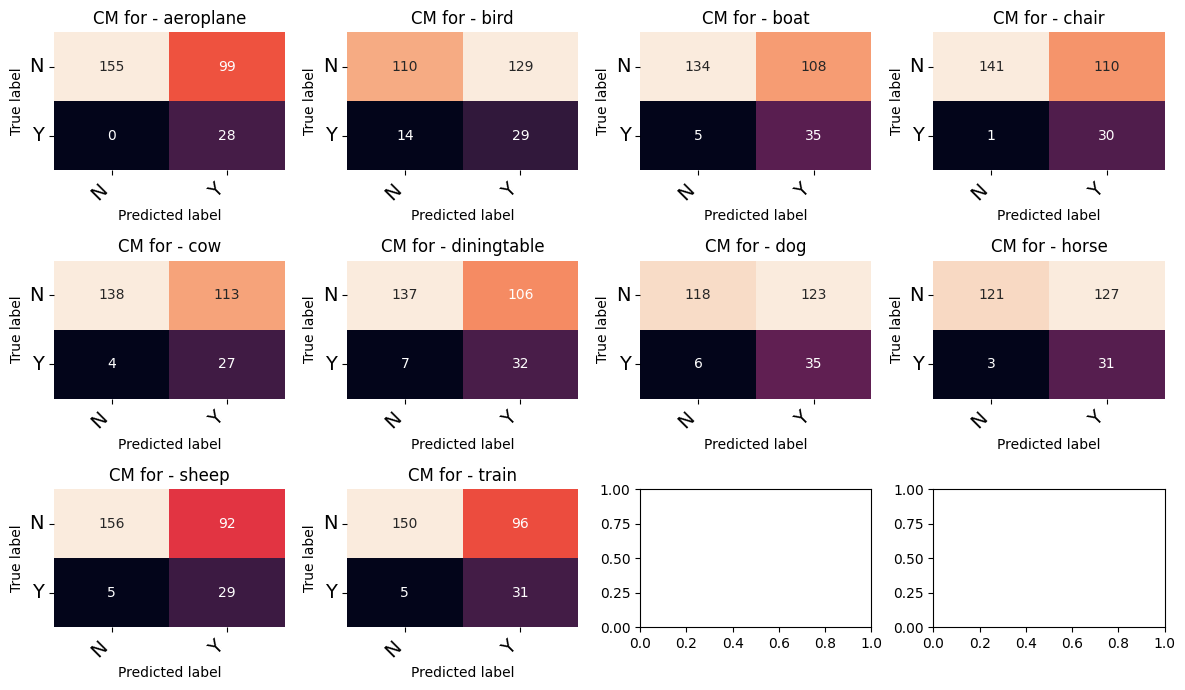

In [22]:
vgg19 = build_vgg19_model()

# Build and log ResNet50 model on balanced data

In [23]:
def load_resnet50_model():
        
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(config.IM_SIZE, config.IM_SIZE, 3), classes=10)
        
    return model

def build_resnet50_model():

    model = load_resnet50_model()
    model = add_last_layers(model)
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])
    
    es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)
    
    resnet_X_train = X_train
    resnet_X_val = X_val
    resnet_X_test = X_test

    resnet_X_train = preproc_resnet(resnet_X_train) 
    resnet_X_val = preproc_resnet(resnet_X_val)
    resnet_X_test = preproc_resnet(resnet_X_test)
    
    history = model.fit(resnet_X_train, y_train, 
                    validation_data=(resnet_X_val, y_val), 
                    epochs=25, 
                    batch_size=32, 
                    callbacks=[es])
    model.save("../raw_data/models/final_resnet50")
    res = model.evaluate(resnet_X_test, y_test)
    res
    test_accuracy = res[-1]
    print(f"test_accuracy = {round(test_accuracy,2)*100} %")
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    y_pred = model.predict(resnet_X_test)
    print(y_pred)
    print("\n\nWhen using 0.5 as threshold\n\n")
    classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
    predictions = (y_pred > 0.5).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using mean probability {np.mean(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.mean(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using median probability {np.median(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.median(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_6 (Dense)             (None, 500)               65536500  
                                                                 
 dense_7 (Dense)             (None, 10)                5010      
                                                                 
Total params: 89,129,222
Trainable params: 65,541,510
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/25
42/42 [==============================] - 7s 112ms/step - loss: 0.5300 - accuracy: 0.4342 - val_loss: 0.2799 - val_accuracy: 0.5284
Epoch 2/25
42/42 [=====

INFO:tensorflow:Assets written to: ../raw_data/models/final_resnet50/assets


INFO:tensorflow:Assets written to: ../raw_data/models/final_resnet50/assets


9/9 [==============================] - 1s 53ms/step - loss: 0.3840 - accuracy: 0.5674
test_accuracy = 56.99999999999999 %


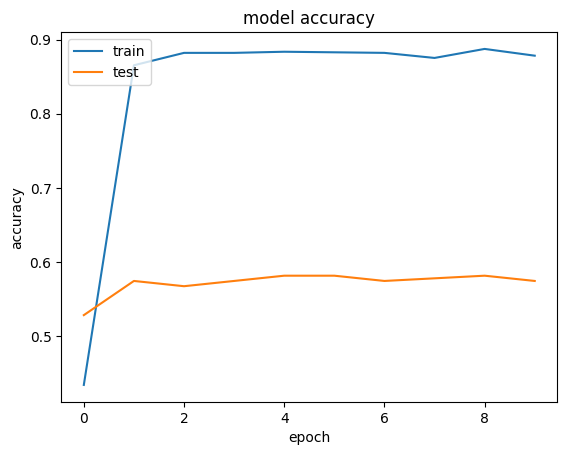

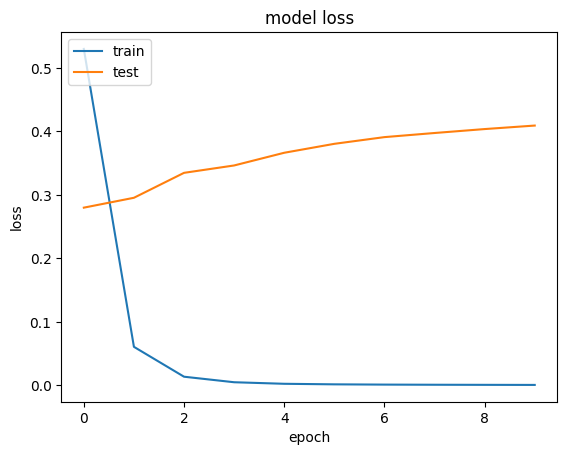

9/9 [==============================] - 1s 50ms/step
[[1.24006299e-04 2.48930912e-04 3.81063111e-02 ... 3.16722994e-03
  1.03472918e-01 1.19703429e-04]
 [3.63511035e-08 2.92703379e-02 2.84213402e-05 ... 2.67880154e-04
  1.16919124e-04 1.90242622e-06]
 [1.12720835e-03 1.01424321e-05 3.64793741e-05 ... 1.88325852e-04
  6.50615675e-07 9.99984384e-01]
 ...
 [2.33212858e-03 3.90846189e-03 2.41273054e-04 ... 7.45434940e-01
  3.32741663e-02 8.81318647e-06]
 [5.11083985e-04 6.39391597e-04 6.47816807e-02 ... 3.79129197e-03
  6.56548422e-03 6.58450244e-06]
 [1.00075362e-04 2.80991895e-04 2.22401798e-01 ... 1.04581658e-02
  8.63225386e-03 2.05516199e-06]]


When using 0.5 as threshold


              precision    recall  f1-score   support

   aeroplane       1.00      0.54      0.70        28
        bird       0.78      0.16      0.27        43
        boat       0.96      0.55      0.70        40
       chair       0.75      0.58      0.65        31
         cow       0.75      0.48      0.59  

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


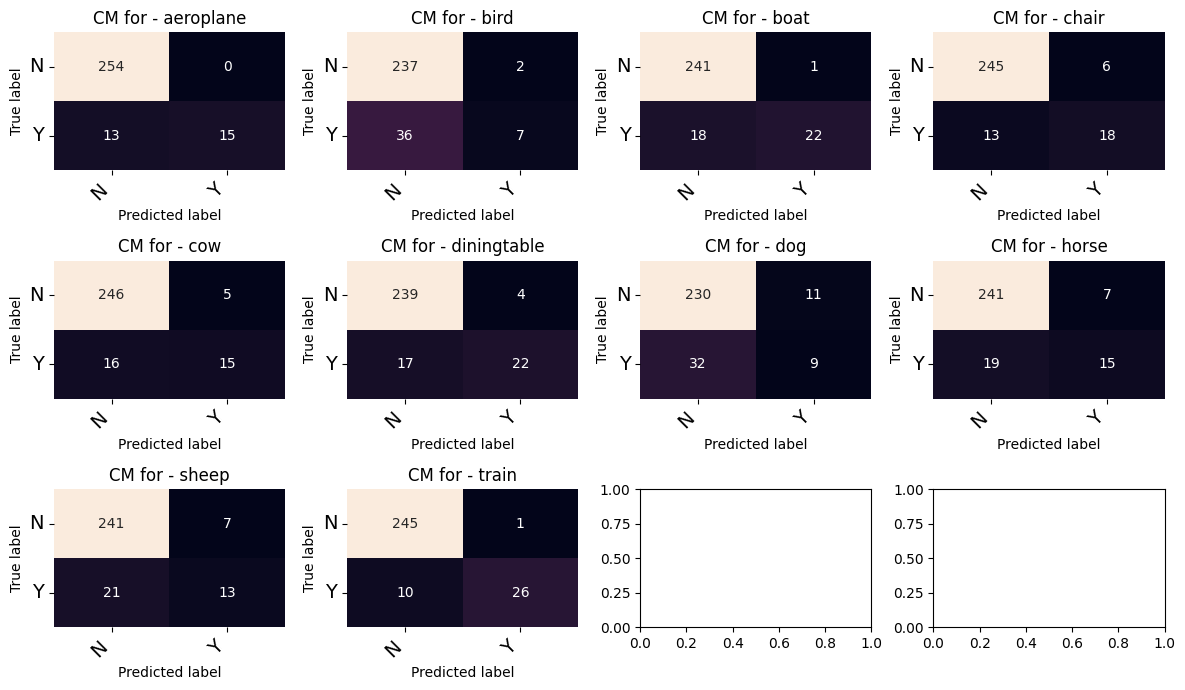



When using mean probability 0.07940961420536041 as threshold


              precision    recall  f1-score   support

   aeroplane       0.65      0.61      0.63        28
        bird       0.62      0.30      0.41        43
        boat       0.73      0.68      0.70        40
       chair       0.69      0.87      0.77        31
         cow       0.48      0.65      0.55        31
 diningtable       0.72      0.72      0.72        39
         dog       0.54      0.46      0.50        41
       horse       0.54      0.59      0.56        34
       sheep       0.59      0.68      0.63        34
       train       0.91      0.81      0.85        36

   micro avg       0.64      0.62      0.63       357
   macro avg       0.65      0.64      0.63       357
weighted avg       0.65      0.62      0.63       357
 samples avg       0.59      0.66      0.60       357

aeroplane      26
bird           21
boat           37
chair          39
cow            42
diningtable    39
dog           

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


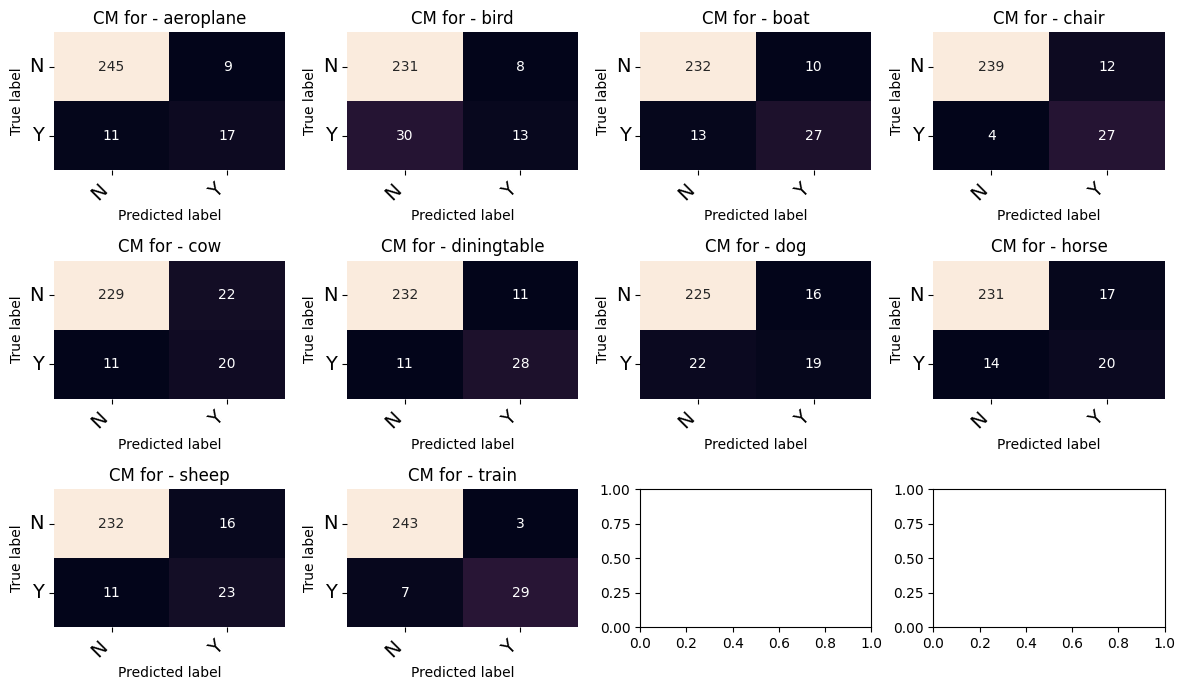



When using median probability 0.00019627297297120094 as threshold


              precision    recall  f1-score   support

   aeroplane       0.19      0.96      0.32        28
        bird       0.18      0.81      0.30        43
        boat       0.24      0.85      0.37        40
       chair       0.37      1.00      0.54        31
         cow       0.22      0.90      0.35        31
 diningtable       0.30      0.97      0.46        39
         dog       0.20      0.90      0.33        41
       horse       0.17      0.97      0.28        34
       sheep       0.26      0.91      0.40        34
       train       0.36      0.92      0.52        36

   micro avg       0.23      0.92      0.37       357
   macro avg       0.25      0.92      0.39       357
weighted avg       0.25      0.92      0.39       357
 samples avg       0.27      0.94      0.40       357

aeroplane      143
bird           194
boat           143
chair           84
cow            127
diningtable    127
dog

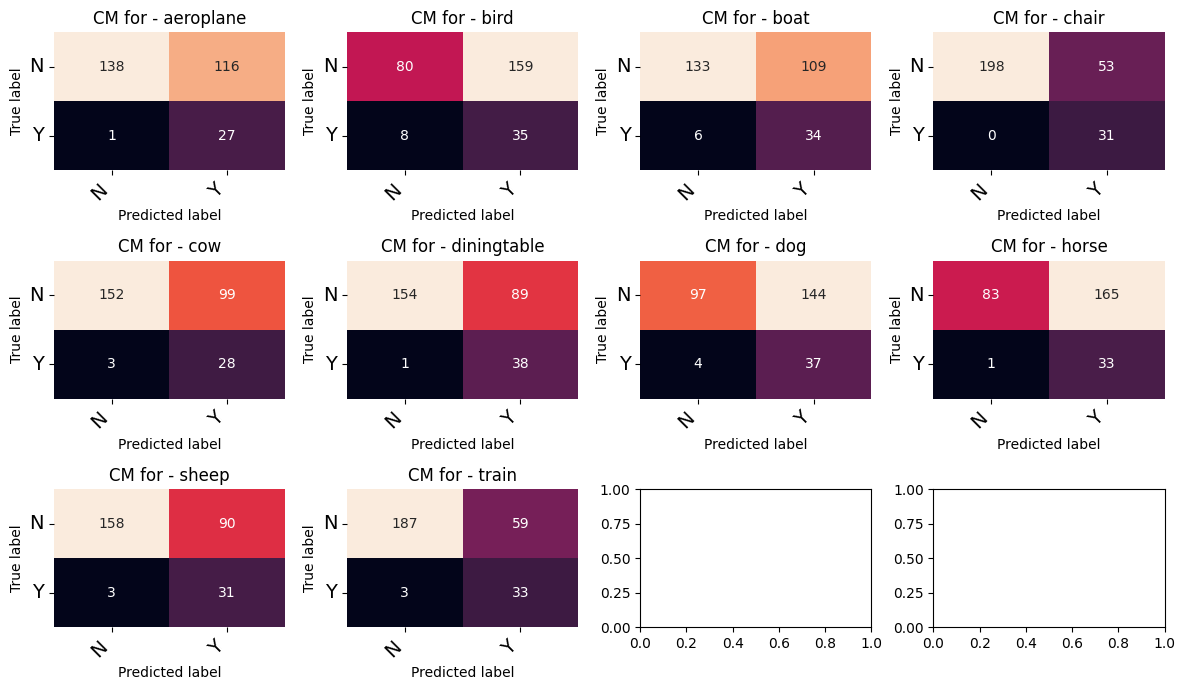

In [24]:
resnet50 = build_resnet50_model()

# Build and log ResNet152 model on balanced data

In [25]:
def load_resnet152_model():
        
    model = ResNet152(weights='imagenet', include_top=False, input_shape=(config.IM_SIZE, config.IM_SIZE, 3), classes=10)
        
    return model

def build_resnet152_model():

    model = load_resnet152_model()
    model = add_last_layers(model)
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])
    
    es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)
    
    resnet_X_train = X_train
    resnet_X_val = X_val
    resnet_X_test = X_test

    resnet_X_train = preproc_resnet(resnet_X_train) 
    resnet_X_val = preproc_resnet(resnet_X_val)
    resnet_X_test = preproc_resnet(resnet_X_test)
    
    history = model.fit(resnet_X_train, y_train, 
                    validation_data=(resnet_X_val, y_val), 
                    epochs=25, 
                    batch_size=32, 
                    callbacks=[es])
    model.save("../raw_data/models/final_resnet152")
    res = model.evaluate(resnet_X_test, y_test)
    res
    test_accuracy = res[-1]
    print(f"test_accuracy = {round(test_accuracy,2)*100} %")
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    y_pred = model.predict(resnet_X_test)
    print(y_pred)
    print("\n\nWhen using 0.5 as threshold\n\n")
    classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
    predictions = (y_pred > 0.5).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using mean probability {np.mean(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.mean(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using median probability {np.median(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.median(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 8, 8, 2048)        58370944  
                                                                 
 flatten_4 (Flatten)         (None, 131072)            0         
                                                                 
 dense_8 (Dense)             (None, 500)               65536500  
                                                                 
 dense_9 (Dense)             (None, 10)                5010      
                                                                 
Total params: 123,912,454
Trainable params: 65,541,510
Non-trainable params: 58,370,944
_________________________________________________________________
Epoch 1/25
42/42 [==============================] - 13s 206ms/step - loss: 0.5548 - accuracy: 0.4563 - val_loss: 0.2818 - val_accuracy: 0.5355
Epoch 2/25
42/42 [===

INFO:tensorflow:Assets written to: ../raw_data/models/final_resnet152/assets


INFO:tensorflow:Assets written to: ../raw_data/models/final_resnet152/assets


9/9 [==============================] - 1s 111ms/step - loss: 0.3960 - accuracy: 0.6170
test_accuracy = 62.0 %


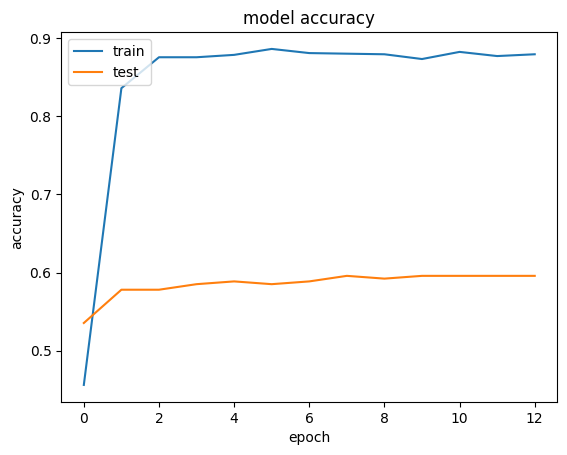

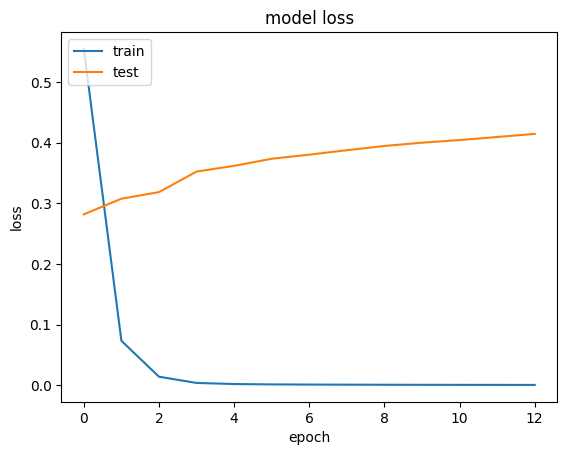

9/9 [==============================] - 3s 130ms/step
[[1.5676706e-06 2.1406839e-05 1.3031086e-04 ... 6.3722497e-01
  1.1574241e-03 3.2284999e-05]
 [6.7036524e-08 3.7171078e-04 1.0986368e-08 ... 5.3010037e-04
  1.2541500e-06 3.0770428e-07]
 [2.7252280e-04 1.8233809e-04 1.3533754e-04 ... 1.7079004e-04
  3.6266524e-06 9.9999142e-01]
 ...
 [2.5233239e-05 1.3122833e-03 1.9780155e-04 ... 8.0963039e-01
  7.1340087e-03 5.3774063e-05]
 [3.4486782e-04 2.2269029e-04 1.3313403e-02 ... 3.6125632e-05
  2.5065005e-02 3.2574718e-04]
 [1.2881267e-03 1.4366440e-03 5.2069628e-01 ... 7.6572556e-04
  2.0068737e-02 4.2211504e-06]]


When using 0.5 as threshold


              precision    recall  f1-score   support

   aeroplane       1.00      0.57      0.73        28
        bird       0.60      0.14      0.23        43
        boat       0.91      0.53      0.67        40
       chair       0.75      0.87      0.81        31
         cow       0.67      0.52      0.58        31
 diningtable       0.77   

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


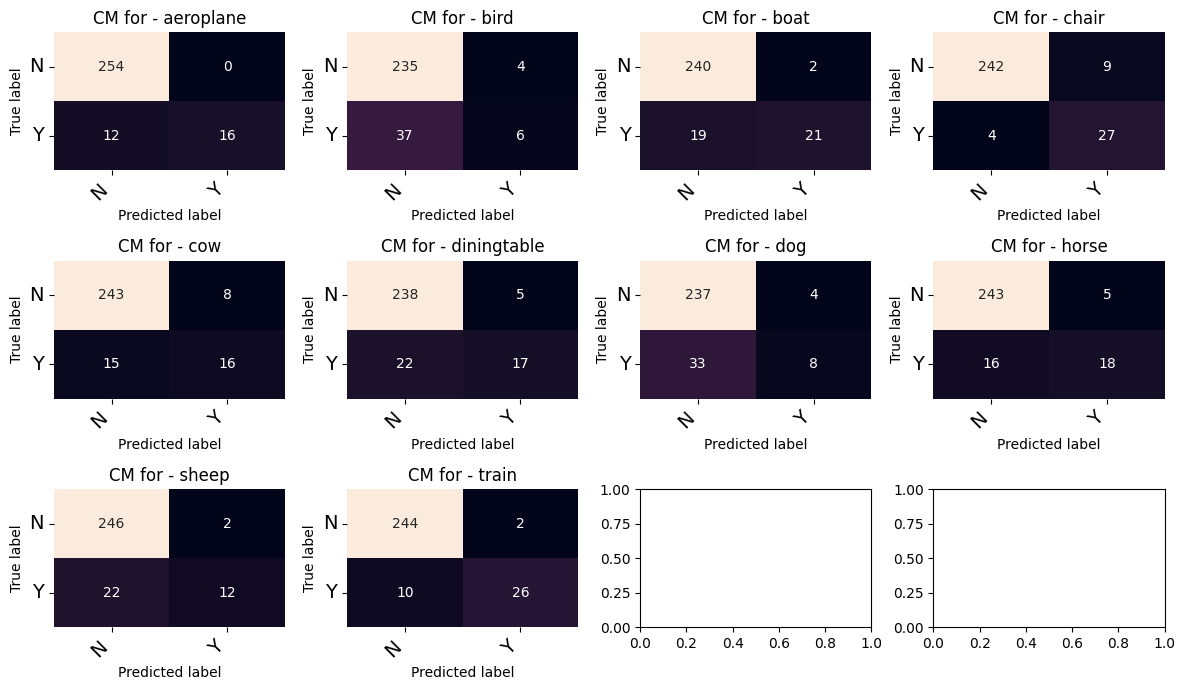



When using mean probability 0.07906483113765717 as threshold


              precision    recall  f1-score   support

   aeroplane       0.95      0.68      0.79        28
        bird       0.52      0.28      0.36        43
        boat       0.77      0.68      0.72        40
       chair       0.71      0.94      0.81        31
         cow       0.57      0.77      0.66        31
 diningtable       0.69      0.62      0.65        39
         dog       0.46      0.39      0.42        41
       horse       0.64      0.68      0.66        34
       sheep       0.59      0.65      0.62        34
       train       0.79      0.75      0.77        36

   micro avg       0.66      0.62      0.64       357
   macro avg       0.67      0.64      0.65       357
weighted avg       0.66      0.62      0.63       357
 samples avg       0.63      0.66      0.62       357

aeroplane      20
bird           23
boat           35
chair          41
cow            42
diningtable    35
dog           

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


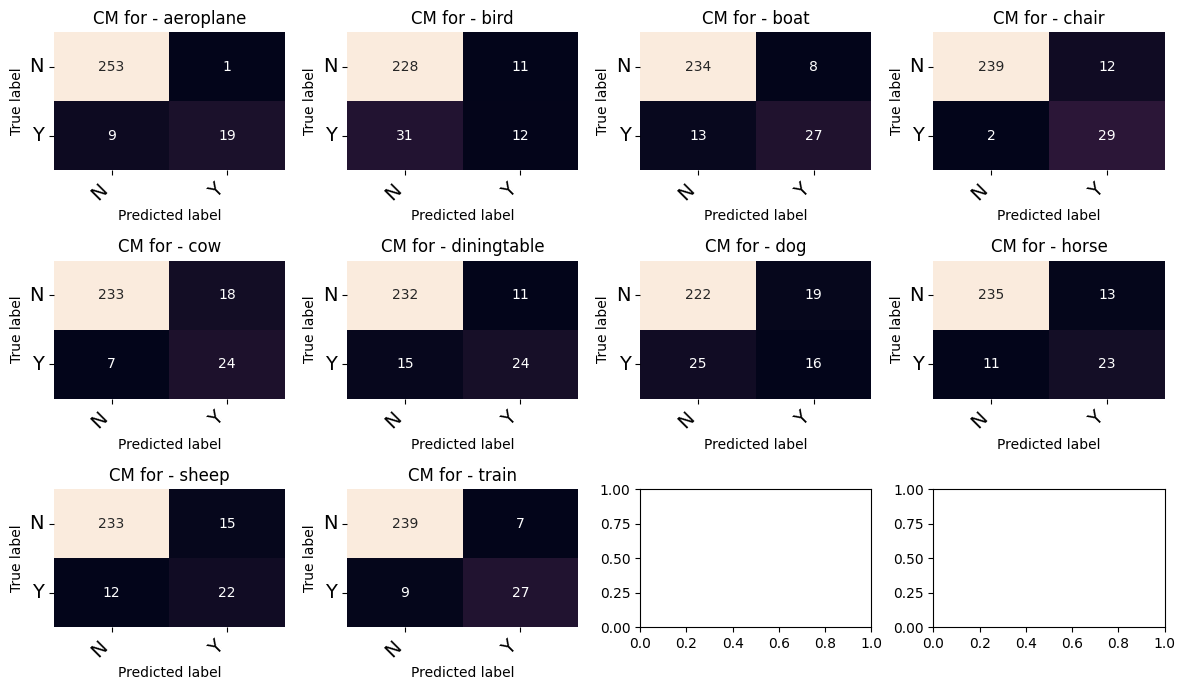



When using median probability 9.982714982470497e-05 as threshold


              precision    recall  f1-score   support

   aeroplane       0.23      0.82      0.35        28
        bird       0.18      0.81      0.30        43
        boat       0.26      0.90      0.40        40
       chair       0.28      1.00      0.44        31
         cow       0.21      0.97      0.35        31
 diningtable       0.29      0.95      0.45        39
         dog       0.20      0.93      0.32        41
       horse       0.18      0.94      0.31        34
       sheep       0.23      0.91      0.37        34
       train       0.34      0.94      0.50        36

   micro avg       0.23      0.92      0.37       357
   macro avg       0.24      0.92      0.38       357
weighted avg       0.24      0.92      0.38       357
 samples avg       0.27      0.94      0.40       357

aeroplane      102
bird           190
boat           139
chair          110
cow            142
diningtable    126
dog 

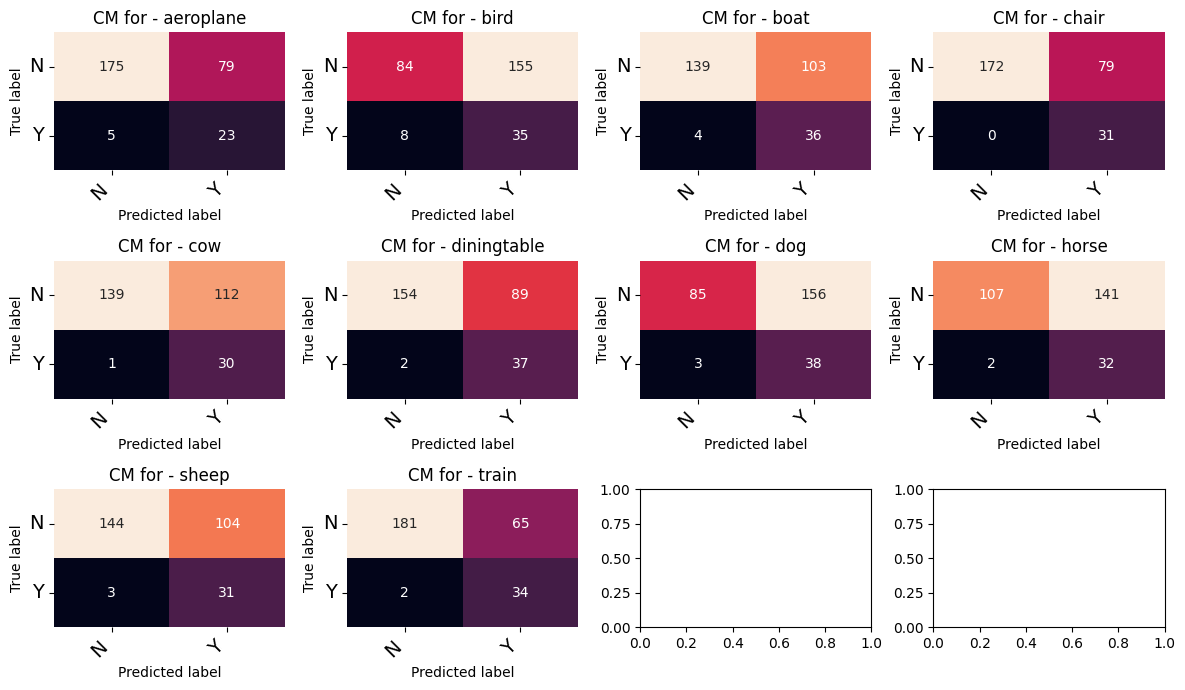

In [26]:
resnet152 = build_resnet152_model()

# Build and log ResNet152V2 model on balanced data

In [27]:
def load_resnet152v2_model():
        
    model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(config.IM_SIZE, config.IM_SIZE, 3), classes=10)
        
    return model

def build_resnet152v2_model():

    model = load_resnet152v2_model()
    model = add_last_layers(model)
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])
    
    es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)
    
    resnet_X_train = X_train
    resnet_X_val = X_val
    resnet_X_test = X_test

    resnet_X_train = preproc_resnet(resnet_X_train) 
    resnet_X_val = preproc_resnet(resnet_X_val)
    resnet_X_test = preproc_resnet(resnet_X_test)
    
    history = model.fit(resnet_X_train, y_train, 
                    validation_data=(resnet_X_val, y_val), 
                    epochs=25, 
                    batch_size=32, 
                    callbacks=[es])
    model.save("../raw_data/models/final_resnet152v2")
    res = model.evaluate(resnet_X_test, y_test)
    res
    test_accuracy = res[-1]
    print(f"test_accuracy = {round(test_accuracy,2)*100} %")
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    y_pred = model.predict(resnet_X_test)
    print(y_pred)
    print("\n\nWhen using 0.5 as threshold\n\n")
    classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
    predictions = (y_pred > 0.5).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using mean probability {np.mean(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.mean(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using median probability {np.median(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.median(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    return model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 flatten_5 (Flatten)         (None, 131072)            0         
                                                                 
 dense_10 (Dense)            (None, 500)               65536500  
                                                                 
 dense_11 (Dense)            (None, 10)                5010      
                                                                 
Total params: 123,873,158
Trainable params: 65,541,510
Non-trainable params: 58,331,648
_________________________________________________________________
Epoch 1/25
42/42 [==============================] - 15s 220ms/step - loss: 367.2383 - accuracy: 0.1506 - val_loss: 66.8784 - val_accuracy: 0.2660
Epoch 2/25
42/42 [

INFO:tensorflow:Assets written to: ../raw_data/models/final_resnet152v2/assets


INFO:tensorflow:Assets written to: ../raw_data/models/final_resnet152v2/assets


9/9 [==============================] - 1s 115ms/step - loss: 70.7805 - accuracy: 0.2305
test_accuracy = 23.0 %


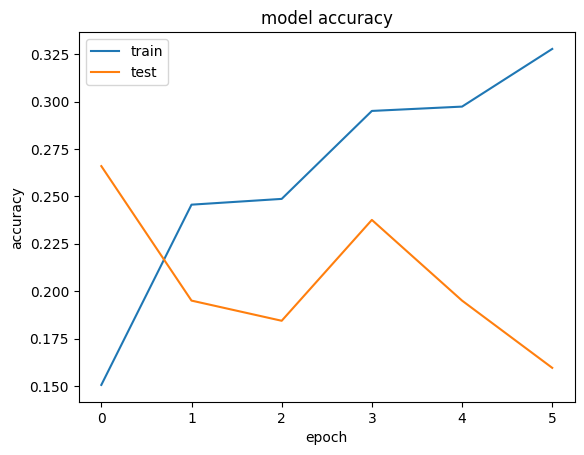

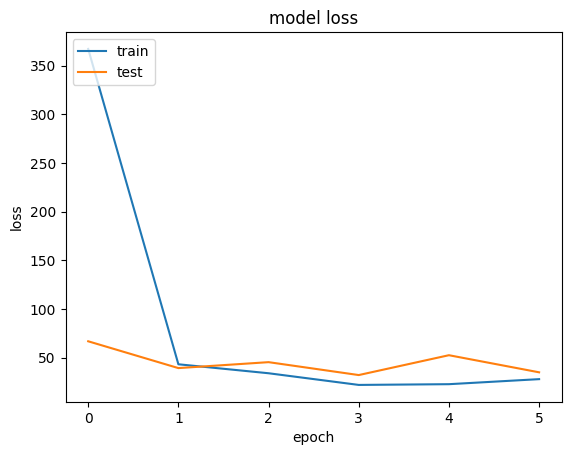

9/9 [==============================] - 3s 133ms/step
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.7019309e-33]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


When using 0.5 as threshold


              precision    recall  f1-score   support

   aeroplane       0.26      0.43      0.32        28
        bird       0.00      0.00      0.00        43
        boat       0.25      0.70      0.37        40
       chair       0.25      0.52      0.34        31
         cow       0.00      0.00      0.00        31
 diningtable       0.00   

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


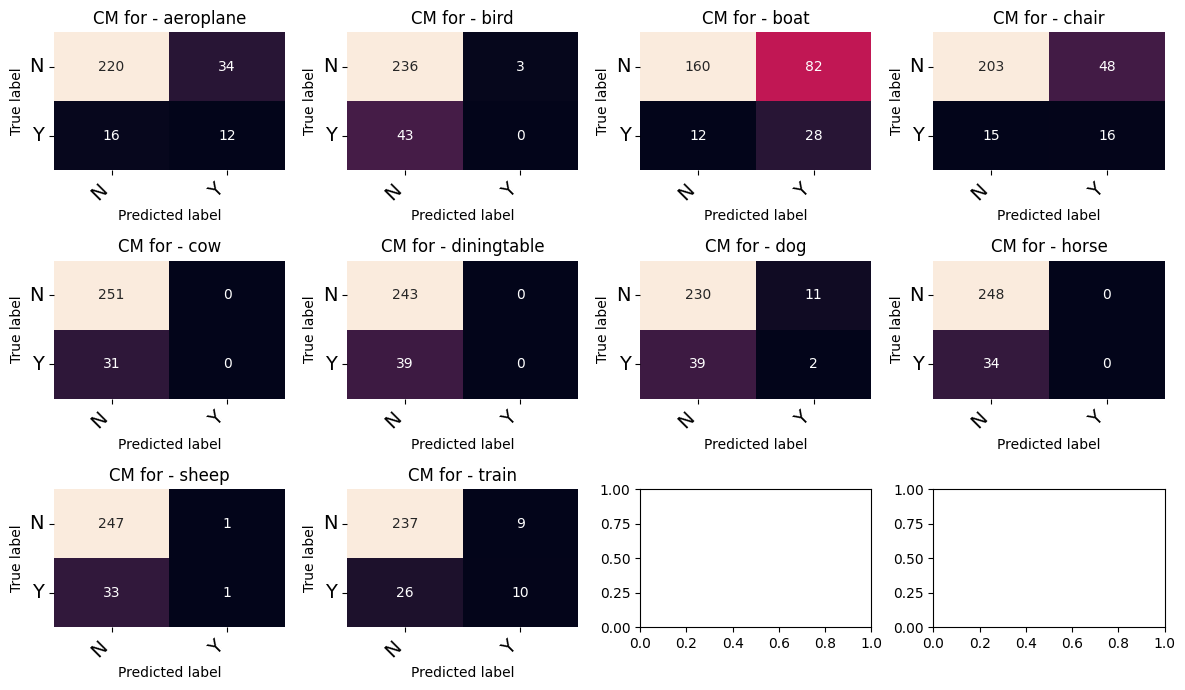



When using mean probability 0.09134038537740707 as threshold


              precision    recall  f1-score   support

   aeroplane       0.26      0.43      0.32        28
        bird       0.00      0.00      0.00        43
        boat       0.25      0.70      0.37        40
       chair       0.25      0.52      0.34        31
         cow       0.00      0.00      0.00        31
 diningtable       0.00      0.00      0.00        39
         dog       0.15      0.05      0.07        41
       horse       0.00      0.00      0.00        34
       sheep       0.50      0.03      0.06        34
       train       0.50      0.28      0.36        36

   micro avg       0.27      0.19      0.22       357
   macro avg       0.19      0.20      0.15       357
weighted avg       0.19      0.19      0.15       357
 samples avg       0.19      0.21      0.19       357

aeroplane       47
bird             3
boat           110
chair           64
cow              0
diningtable      0
dog     

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


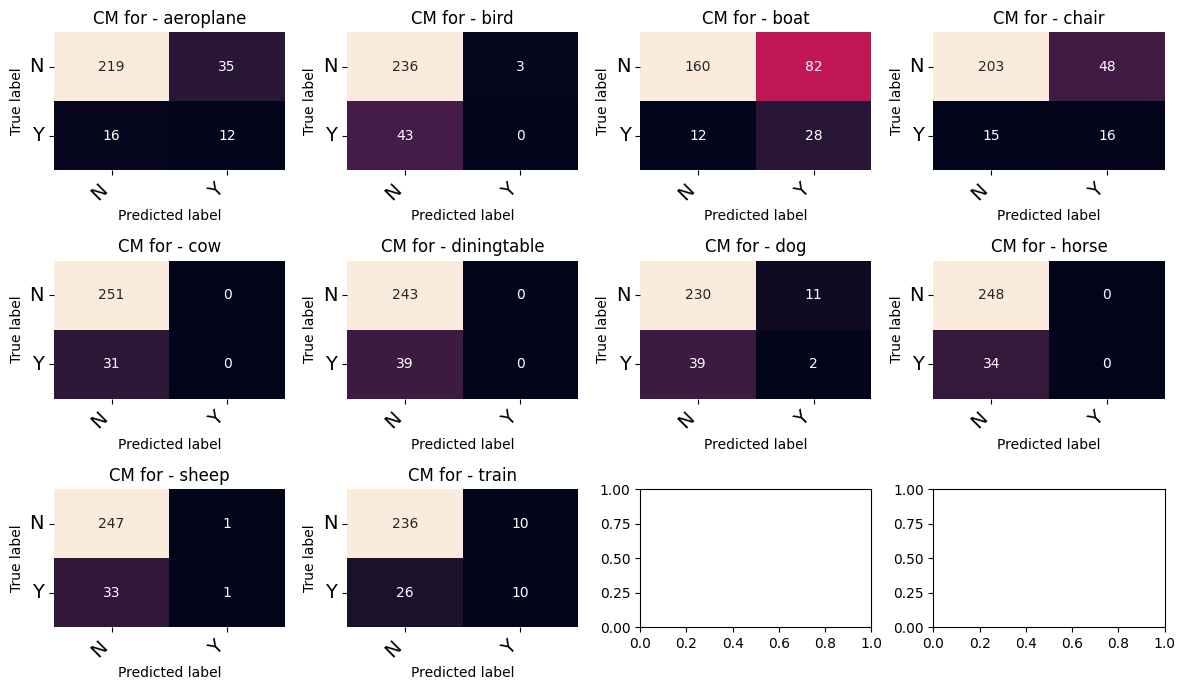



When using median probability 0.0 as threshold


              precision    recall  f1-score   support

   aeroplane       0.24      0.57      0.34        28
        bird       0.13      0.05      0.07        43
        boat       0.24      0.82      0.37        40
       chair       0.23      0.58      0.33        31
         cow       0.00      0.00      0.00        31
 diningtable       0.00      0.00      0.00        39
         dog       0.16      0.22      0.18        41
       horse       0.00      0.00      0.00        34
       sheep       0.50      0.03      0.06        34
       train       0.44      0.44      0.44        36

   micro avg       0.24      0.27      0.25       357
   macro avg       0.20      0.27      0.18       357
weighted avg       0.19      0.27      0.18       357
 samples avg       0.23      0.29      0.24       357

aeroplane       66
bird            15
boat           137
chair           77
cow              0
diningtable      1
dog             57
hor

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


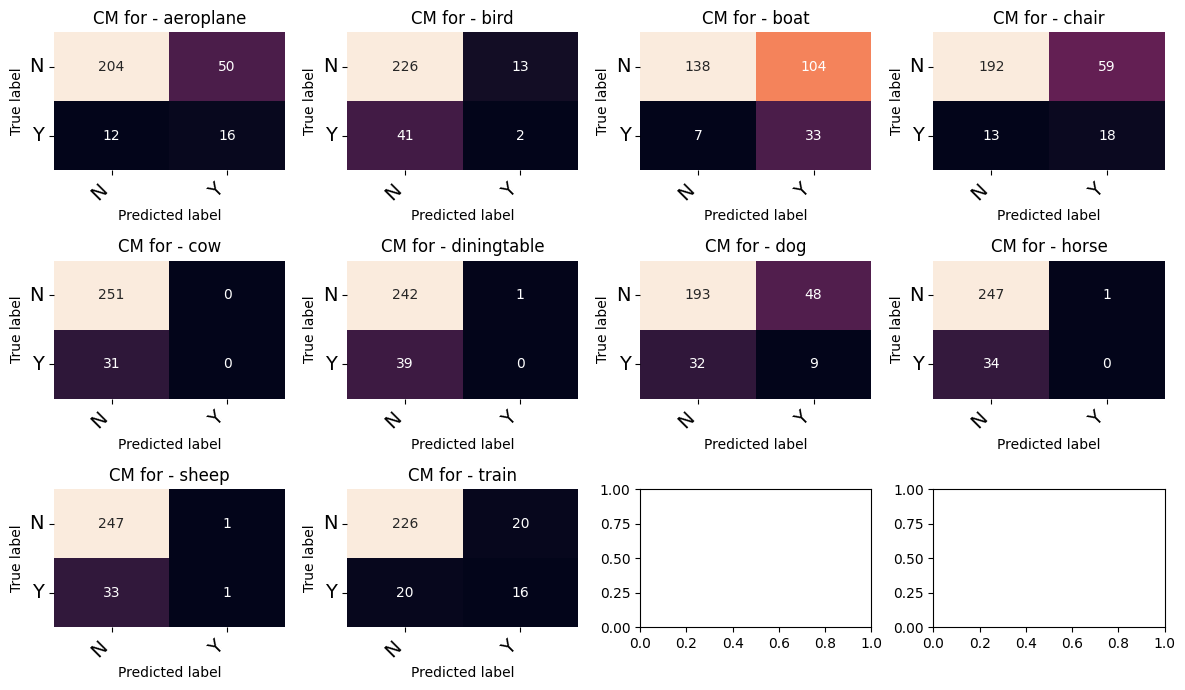

In [28]:
resnet152v2 = build_resnet152v2_model()

# Build and log InceptionV3 model on balanced data

In [29]:
def load_inceptionv3_model():
        
    model = InceptionV3(weights='imagenet', include_top=False, input_shape=(config.IM_SIZE, config.IM_SIZE, 3), classes=10)
        
    return model

def build_inceptionv3_model():

    model = load_inceptionv3_model()
    model = add_last_layers(model)
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])
    
    es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)
    
    inception_X_train = X_train
    inception_X_val = X_val
    inception_X_test = X_test

    inception_X_train = preproc_inception(inception_X_train) 
    inception_X_val = preproc_inception(inception_X_val)
    inception_X_test = preproc_inception(inception_X_test)
    
    history = model.fit(inception_X_train, y_train, 
                    validation_data=(inception_X_val, y_val), 
                    epochs=25, 
                    batch_size=32, 
                    callbacks=[es])
    model.save("../raw_data/models/final_inception")
    res = model.evaluate(inception_X_test, y_test)
    res
    test_accuracy = res[-1]
    print(f"test_accuracy = {round(test_accuracy,2)*100} %")
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    y_pred = model.predict(inception_X_test)
    print(y_pred)
    print("\n\nWhen using 0.5 as threshold\n\n")
    classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
    predictions = (y_pred > 0.5).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using mean probability {np.mean(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.mean(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using median probability {np.median(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.median(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_6 (Flatten)         (None, 73728)             0         
                                                                 
 dense_12 (Dense)            (None, 500)               36864500  
                                                                 
 dense_13 (Dense)            (None, 10)                5010      
                                                                 
Total params: 58,672,294
Trainable params: 36,869,510
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 0.4625 - accuracy: 0.4259

2022-09-26 01:33:46.695044: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 2257059840 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 629469184/8589410304
2022-09-26 01:33:46.695085: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      5510159064
MaxInUse:                   7578655676
NumAllocs:                     1941458
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:33:46.695140: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:33:46.695144: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocato

42/42 [==============================] - 11s 167ms/step - loss: 0.4625 - accuracy: 0.4259 - val_loss: 0.2714 - val_accuracy: 0.5071
Epoch 2/25
42/42 [==============================] - 3s 66ms/step - loss: 0.1268 - accuracy: 0.7795 - val_loss: 0.2673 - val_accuracy: 0.5142
Epoch 3/25
42/42 [==============================] - 3s 65ms/step - loss: 0.0585 - accuracy: 0.8646 - val_loss: 0.2760 - val_accuracy: 0.5390
Epoch 4/25
42/42 [==============================] - 3s 65ms/step - loss: 0.0339 - accuracy: 0.8989 - val_loss: 0.2878 - val_accuracy: 0.5957
Epoch 5/25
42/42 [==============================] - 3s 61ms/step - loss: 0.0201 - accuracy: 0.8958 - val_loss: 0.3125 - val_accuracy: 0.5638
Epoch 6/25
42/42 [==============================] - 3s 61ms/step - loss: 0.0113 - accuracy: 0.8897 - val_loss: 0.3071 - val_accuracy: 0.5532
Epoch 7/25
42/42 [==============================] - 3s 62ms/step - loss: 0.0077 - accuracy: 0.8837 - val_loss: 0.3246 - val_accuracy: 0.5638
Epoch 8/25
42/42 [====

INFO:tensorflow:Assets written to: ../raw_data/models/final_inception/assets


INFO:tensorflow:Assets written to: ../raw_data/models/final_inception/assets


9/9 [==============================] - 1s 40ms/step - loss: 0.2913 - accuracy: 0.5709
test_accuracy = 56.99999999999999 %


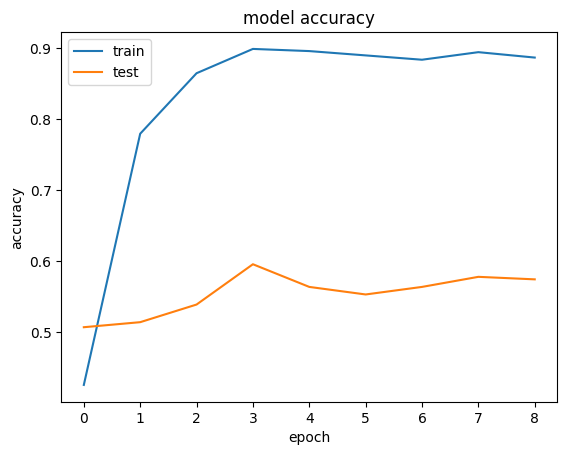

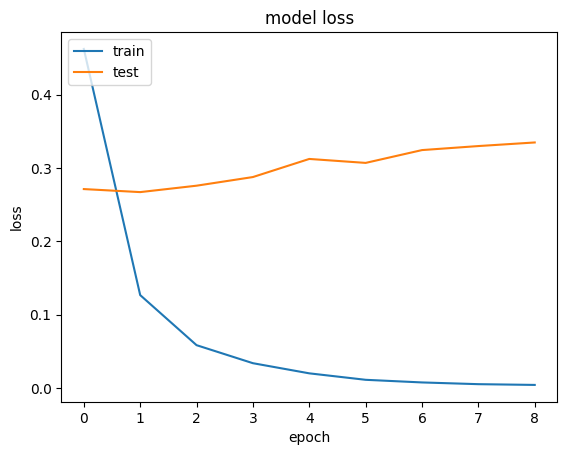

9/9 [==============================] - 1s 37ms/step
[[6.82908576e-04 3.01969849e-04 1.75450390e-04 ... 1.21446148e-01
  3.31555679e-03 1.48637619e-05]
 [1.42814824e-04 1.25379115e-02 1.93107640e-04 ... 2.23390432e-03
  1.32681173e-03 7.48171151e-05]
 [3.31717054e-03 3.20993240e-05 7.50781735e-04 ... 3.49406124e-04
  8.79212894e-05 9.99996781e-01]
 ...
 [2.30766973e-03 2.36308984e-02 1.03462196e-03 ... 9.91768956e-01
  6.46378263e-04 3.98191996e-03]
 [1.65844727e-02 2.59889457e-02 2.64954325e-02 ... 6.71915635e-02
  4.64406282e-01 2.12291069e-03]
 [6.30241707e-02 1.55364107e-02 2.85546720e-01 ... 3.62889059e-02
  2.41770983e-01 4.31514904e-03]]


When using 0.5 as threshold


              precision    recall  f1-score   support

   aeroplane       0.75      0.64      0.69        28
        bird       0.57      0.09      0.16        43
        boat       0.85      0.55      0.67        40
       chair       0.72      0.68      0.70        31
         cow       0.59      0.71      0.65  

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


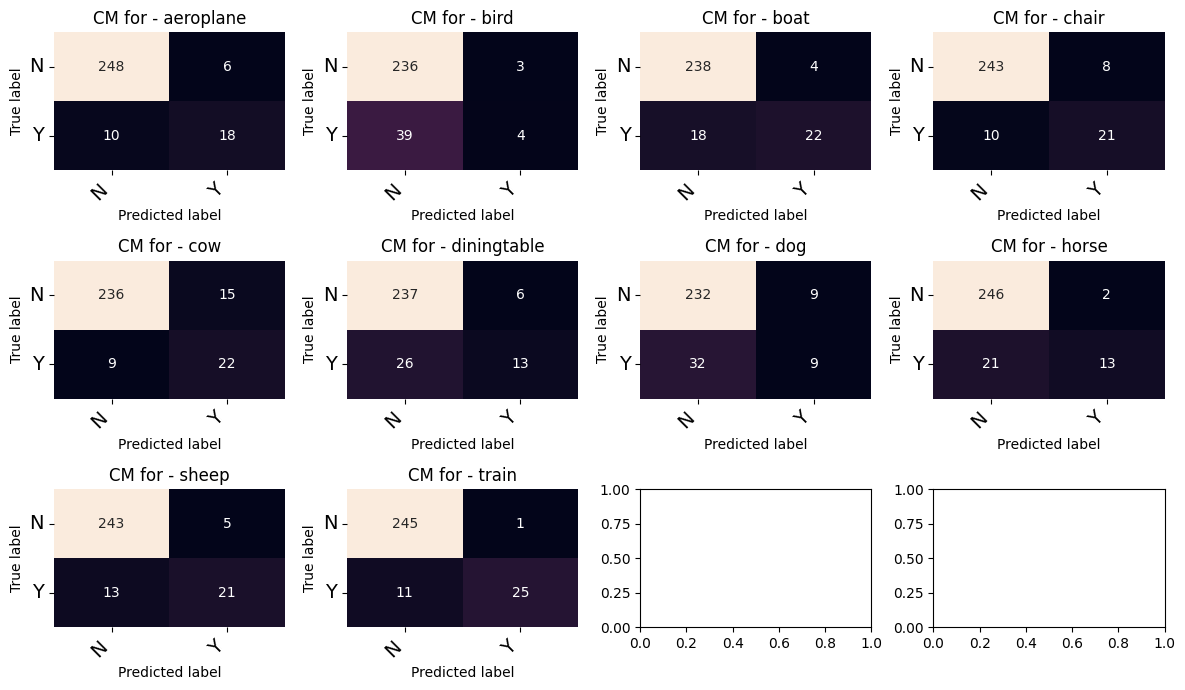



When using mean probability 0.0973891094326973 as threshold


              precision    recall  f1-score   support

   aeroplane       0.52      0.79      0.63        28
        bird       0.31      0.26      0.28        43
        boat       0.62      0.72      0.67        40
       chair       0.63      0.87      0.73        31
         cow       0.37      0.81      0.51        31
 diningtable       0.62      0.82      0.70        39
         dog       0.52      0.66      0.58        41
       horse       0.56      0.65      0.60        34
       sheep       0.52      0.74      0.61        34
       train       0.82      0.75      0.78        36

   micro avg       0.54      0.69      0.61       357
   macro avg       0.55      0.71      0.61       357
weighted avg       0.55      0.69      0.60       357
 samples avg       0.57      0.73      0.61       357

aeroplane      42
bird           35
boat           47
chair          43
cow            68
diningtable    52
dog            

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


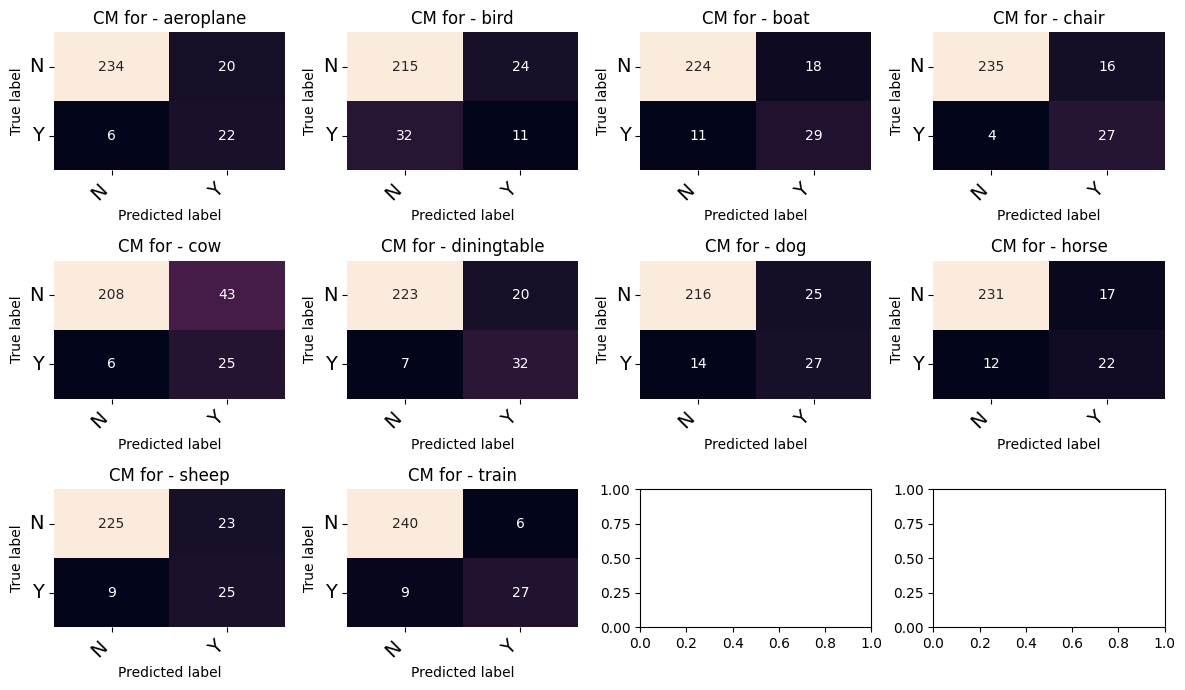



When using median probability 0.002660934580489993 as threshold


              precision    recall  f1-score   support

   aeroplane       0.19      1.00      0.32        28
        bird       0.21      0.84      0.34        43
        boat       0.26      0.95      0.40        40
       chair       0.34      0.97      0.50        31
         cow       0.17      0.94      0.29        31
 diningtable       0.30      0.97      0.46        39
         dog       0.20      0.98      0.33        41
       horse       0.22      0.94      0.36        34
       sheep       0.22      0.85      0.35        34
       train       0.37      0.89      0.52        36

   micro avg       0.24      0.93      0.38       357
   macro avg       0.25      0.93      0.39       357
weighted avg       0.25      0.93      0.39       357
 samples avg       0.28      0.94      0.40       357

aeroplane      146
bird           171
boat           148
chair           89
cow            166
diningtable    128
dog  

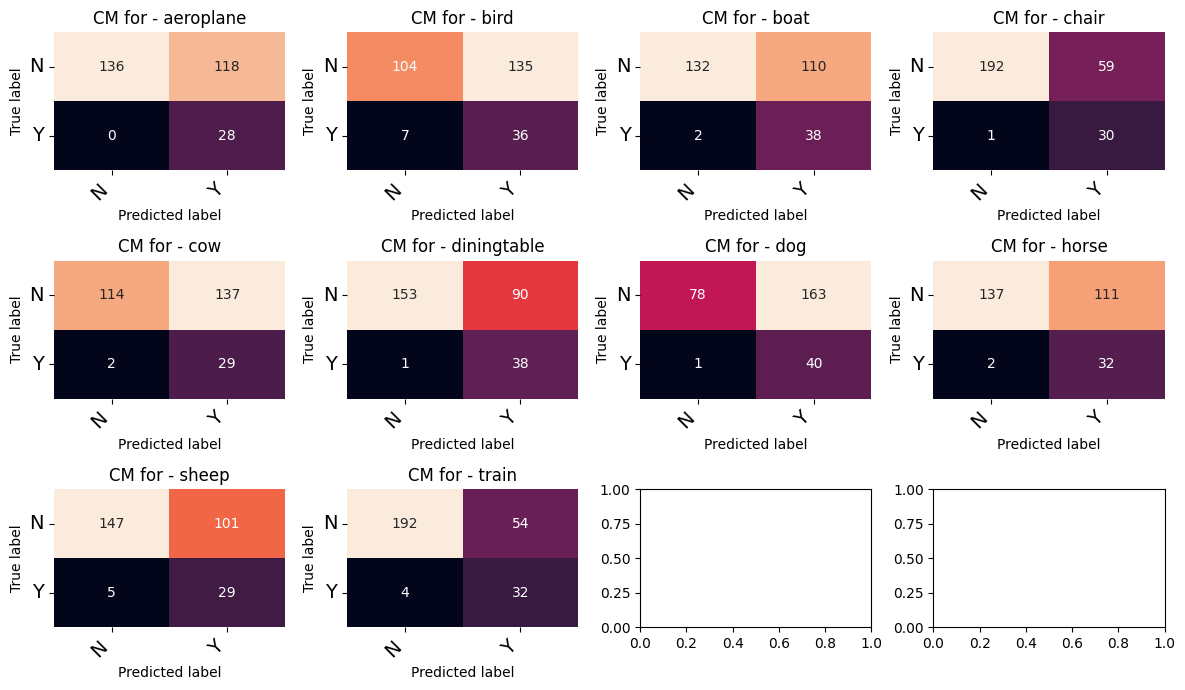

In [30]:
inceptionv3 = build_inceptionv3_model()

# Build and log InceptionResnetV2 model on balanced data

In [31]:
def load_inceptionv2_model():
        
    model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(config.IM_SIZE, config.IM_SIZE, 3), classes=10)
        
    return model

def build_inceptionv2_model():

    model = load_inceptionv2_model()
    model = add_last_layers(model)
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])
    
    es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)
    
    inceptionv2_X_train = X_train
    inceptionv2_X_val = X_val
    inceptionv2_X_test = X_test

    inceptionv2_X_train = preproc_inceptionv2(inceptionv2_X_train) 
    inceptionv2_X_val = preproc_inceptionv2(inceptionv2_X_val)
    inceptionv2_X_test = preproc_inceptionv2(inceptionv2_X_test)
    
    history = model.fit(inceptionv2_X_train, y_train, 
                    validation_data=(inceptionv2_X_val, y_val), 
                    epochs=25, 
                    batch_size=32, 
                    callbacks=[es])
    model.save("../raw_data/models/final_inceptionresnetv2")
    res = model.evaluate(inceptionv2_X_test, y_test)
    res
    test_accuracy = res[-1]
    print(f"test_accuracy = {round(test_accuracy,2)*100} %")
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    y_pred = model.predict(inceptionv2_X_test)
    print(y_pred)
    print("\n\nWhen using 0.5 as threshold\n\n")
    classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
    predictions = (y_pred > 0.5).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using mean probability {np.mean(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.mean(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using median probability {np.median(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.median(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    return model

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 55296)             0         
                                                                 
 dense_14 (Dense)            (None, 500)               27648500  
                                                                 
 dense_15 (Dense)            (None, 10)                5010      
                                                                 
Total params: 81,990,246
Trainable params: 27,653,510
Non-trainable params: 54,336,736
_________________________________________________________________
Epoch 1/25
 1/42 [..............................] - ETA: 5:09 - loss: 1.0088 - accuracy: 0.0938

2022-09-26 01:34:47.813386: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 2200494080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 743440384/8589410304
2022-09-26 01:34:47.813424: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      5625449336
MaxInUse:                   7578655676
NumAllocs:                     2334720
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:34:47.813509: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:34:47.813513: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocato

42/42 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.4479

2022-09-26 01:34:53.323782: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 2170560512 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 776994816/8589410304
2022-09-26 01:34:53.323819: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      5597518872
MaxInUse:                   7578655676
NumAllocs:                     2417881
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:34:53.323906: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:34:53.323910: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocato

2022-09-26 01:34:57.387983: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 2194300928 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 518799360/8589410304
2022-09-26 01:34:57.388030: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      5841467040
MaxInUse:                   7578655676
NumAllocs:                     2436171
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:34:57.388116: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:34:57.388120: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocato

42/42 [==============================] - 18s 244ms/step - loss: 0.4071 - accuracy: 0.4479 - val_loss: 0.2481 - val_accuracy: 0.5993
Epoch 2/25
42/42 [==============================] - 6s 142ms/step - loss: 0.1392 - accuracy: 0.7468 - val_loss: 0.2330 - val_accuracy: 0.5851
Epoch 3/25
42/42 [==============================] - 6s 144ms/step - loss: 0.0798 - accuracy: 0.8319 - val_loss: 0.2486 - val_accuracy: 0.6135
Epoch 4/25
42/42 [==============================] - 6s 140ms/step - loss: 0.0446 - accuracy: 0.8760 - val_loss: 0.2533 - val_accuracy: 0.6170
Epoch 5/25
42/42 [==============================] - 6s 133ms/step - loss: 0.0259 - accuracy: 0.8852 - val_loss: 0.2697 - val_accuracy: 0.5957
Epoch 6/25
42/42 [==============================] - 6s 134ms/step - loss: 0.0180 - accuracy: 0.8875 - val_loss: 0.2856 - val_accuracy: 0.5851
Epoch 7/25
42/42 [==============================] - 6s 140ms/step - loss: 0.0118 - accuracy: 0.8798 - val_loss: 0.3163 - val_accuracy: 0.6241
Epoch 8/25
42/42

INFO:tensorflow:Assets written to: ../raw_data/models/final_inceptionresnetv2/assets


INFO:tensorflow:Assets written to: ../raw_data/models/final_inceptionresnetv2/assets


9/9 [==============================] - 1s 103ms/step - loss: 0.3056 - accuracy: 0.6135
test_accuracy = 61.0 %


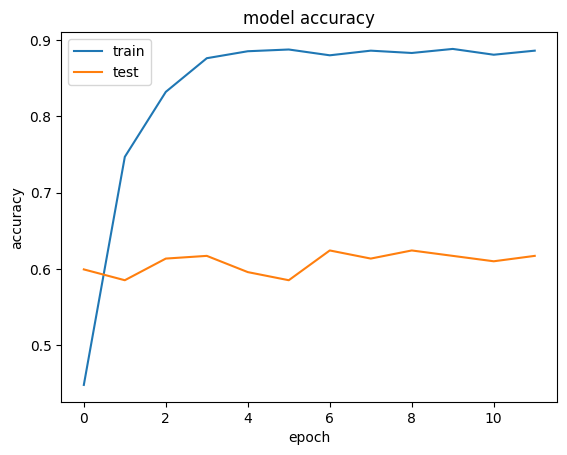

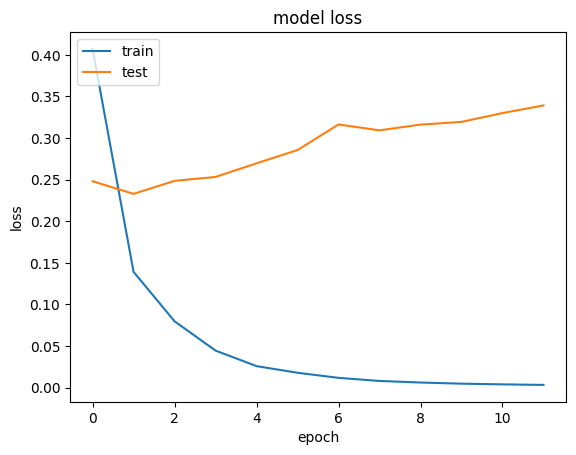

9/9 [==============================] - 3s 127ms/step
[[2.0155519e-06 2.8187272e-03 3.0318607e-04 ... 1.5117319e-01
  3.2915186e-02 4.6064710e-05]
 [1.9498286e-06 1.7928375e-03 1.7917509e-05 ... 2.8508604e-02
  1.8653823e-03 2.3238394e-05]
 [3.5509196e-04 2.0456270e-04 8.3897129e-04 ... 2.9343661e-04
  6.4723566e-04 9.9999988e-01]
 ...
 [9.4936813e-06 2.5465311e-03 1.7481156e-05 ... 9.8279816e-01
  3.4140956e-04 1.2870946e-03]
 [6.0245753e-03 3.1671501e-03 1.4505405e-02 ... 6.5597050e-02
  3.9853877e-01 1.2738269e-03]
 [9.1907578e-03 3.1952784e-04 4.6279958e-01 ... 5.0039071e-01
  4.4469360e-02 4.6767227e-04]]


When using 0.5 as threshold


              precision    recall  f1-score   support

   aeroplane       1.00      0.57      0.73        28
        bird       1.00      0.14      0.24        43
        boat       0.82      0.57      0.68        40
       chair       0.71      0.87      0.78        31
         cow       0.60      0.58      0.59        31
 diningtable       0.78   

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


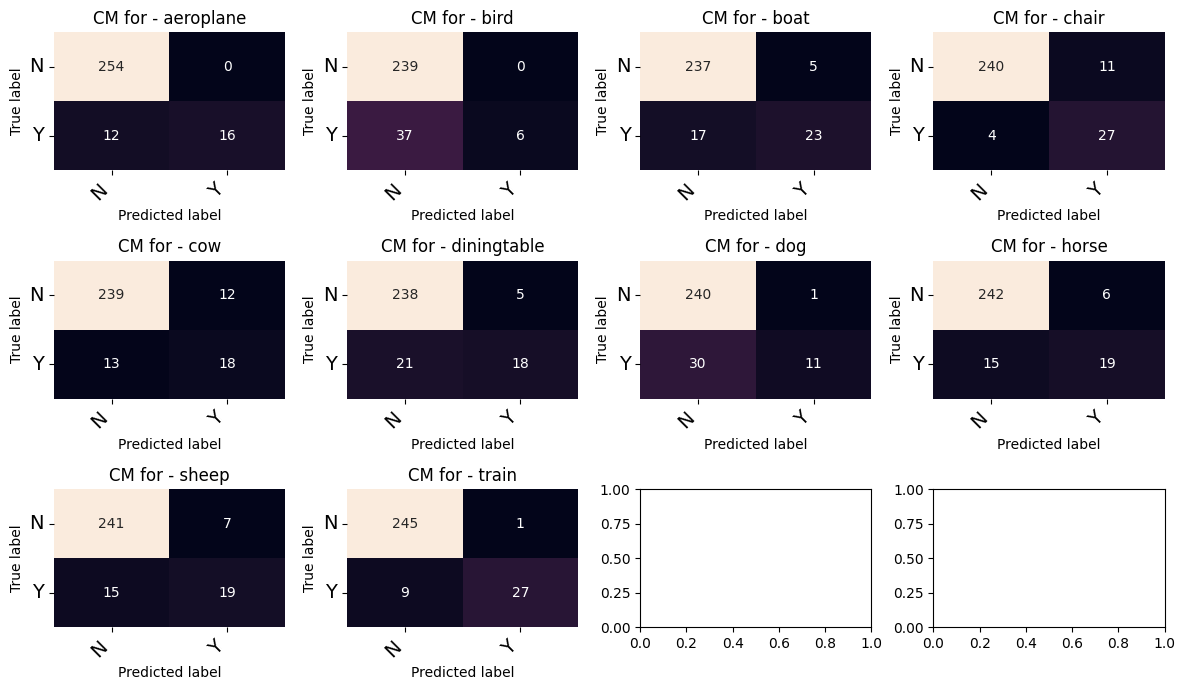



When using mean probability 0.0918307900428772 as threshold


              precision    recall  f1-score   support

   aeroplane       0.75      0.64      0.69        28
        bird       0.57      0.28      0.37        43
        boat       0.69      0.72      0.71        40
       chair       0.58      0.90      0.71        31
         cow       0.48      0.74      0.58        31
 diningtable       0.75      0.77      0.76        39
         dog       0.57      0.49      0.53        41
       horse       0.48      0.74      0.58        34
       sheep       0.53      0.76      0.63        34
       train       0.77      0.75      0.76        36

   micro avg       0.60      0.67      0.63       357
   macro avg       0.62      0.68      0.63       357
weighted avg       0.62      0.67      0.63       357
 samples avg       0.63      0.71      0.64       357

aeroplane      24
bird           21
boat           42
chair          48
cow            48
diningtable    40
dog            

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


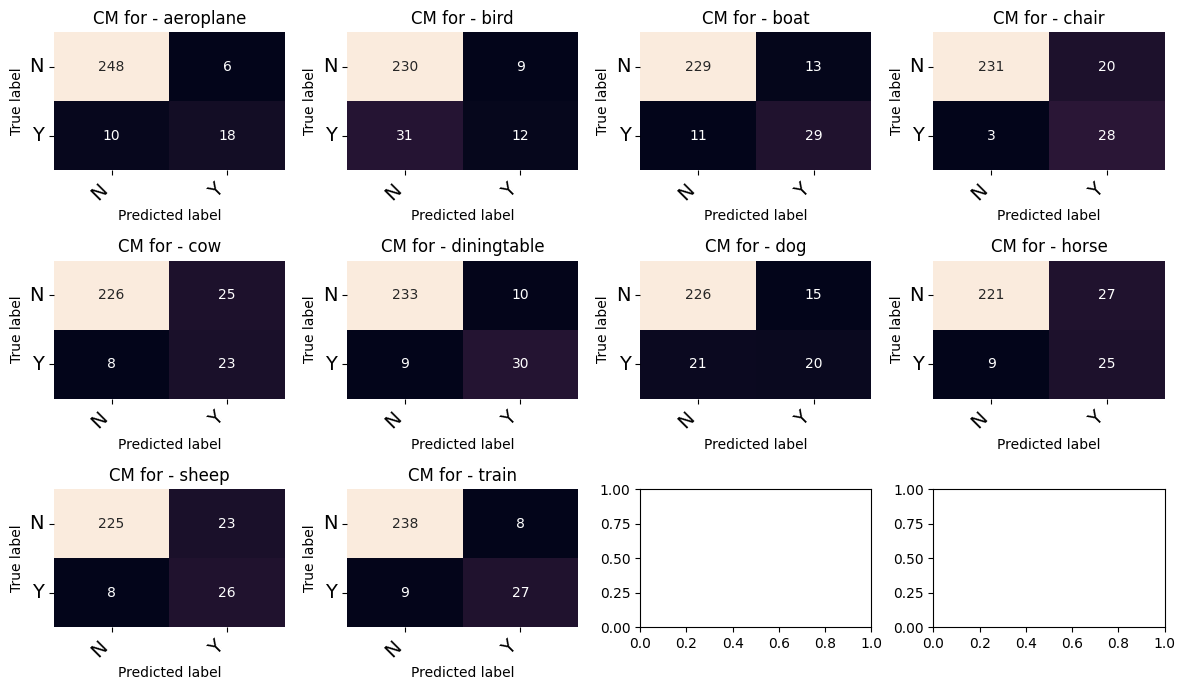



When using median probability 0.0007540148799307644 as threshold


              precision    recall  f1-score   support

   aeroplane       0.23      0.93      0.36        28
        bird       0.23      0.77      0.35        43
        boat       0.27      0.97      0.43        40
       chair       0.26      1.00      0.42        31
         cow       0.22      0.97      0.36        31
 diningtable       0.31      0.95      0.47        39
         dog       0.18      0.90      0.31        41
       horse       0.18      0.88      0.30        34
       sheep       0.23      0.94      0.37        34
       train       0.27      0.94      0.41        36

   micro avg       0.23      0.92      0.37       357
   macro avg       0.24      0.93      0.38       357
weighted avg       0.24      0.92      0.38       357
 samples avg       0.29      0.93      0.41       357

aeroplane      115
bird           145
boat           142
chair          118
cow            138
diningtable    118
dog 

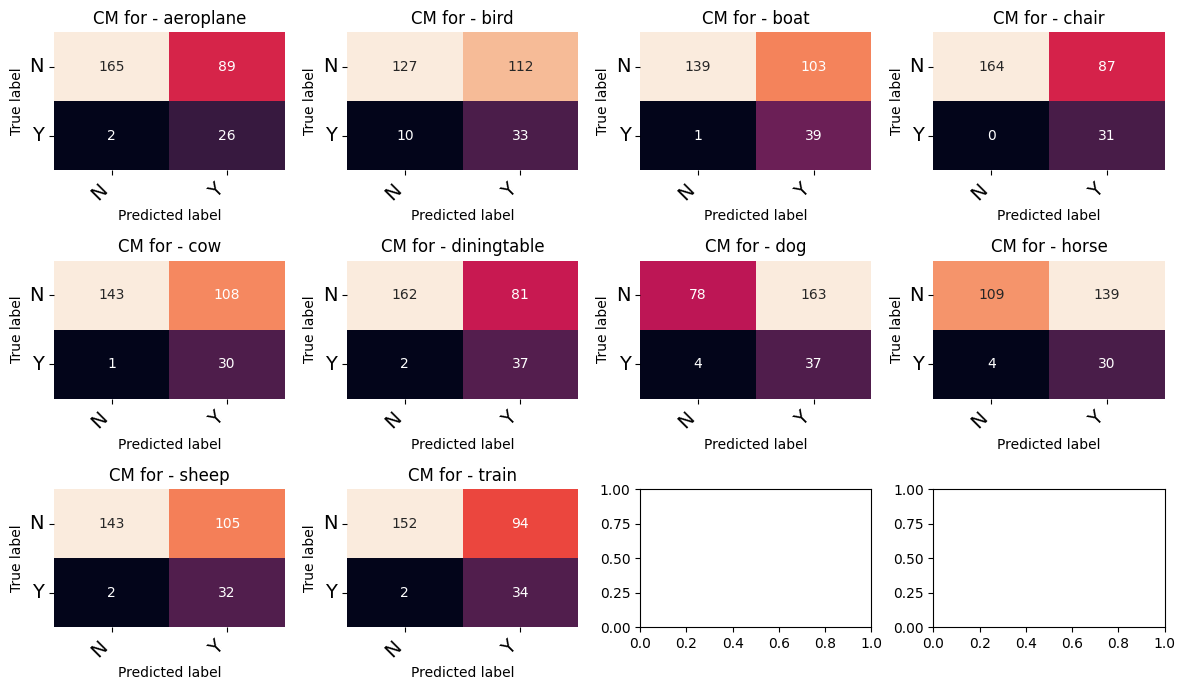

In [32]:
inceptionv2 = build_inceptionv2_model()

# Build and log Xception model on balanced data

In [33]:
def load_xception_model():
        
    model = Xception(weights='imagenet', include_top=False, input_shape=(config.IM_SIZE, config.IM_SIZE, 3), classes=10)
        
    return model

def build_xception_model():

    model = load_xception_model()
    model = add_last_layers(model)
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])
    
    es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)
    
    xception_X_train = X_train
    xception_X_val = X_val
    xception_X_test = X_test

    xception_X_train = preproc_xception(xception_X_train) 
    xception_X_val = preproc_xception(xception_X_val)
    xception_X_test = preproc_xception(xception_X_test)
    
    history = model.fit(xception_X_train, y_train, 
                    validation_data=(xception_X_val, y_val), 
                    epochs=25, 
                    batch_size=32, 
                    callbacks=[es])
    model.save("../raw_data/models/final_xception")
    res = model.evaluate(xception_X_test, y_test)
    res
    test_accuracy = res[-1]
    print(f"test_accuracy = {round(test_accuracy,2)*100} %")
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    y_pred = model.predict(xception_X_test)
    print(y_pred)
    print("\n\nWhen using 0.5 as threshold\n\n")
    classes = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
    predictions = (y_pred > 0.5).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using mean probability {np.mean(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.mean(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    
    print(f"\n\nWhen using median probability {np.median(y_pred)} as threshold\n\n")
    predictions = (y_pred > np.median(y_pred)).astype("int32")
    print(classification_report(y_test, predictions, output_dict=False, target_names=classes))
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']
    print(predictions_df.sum())
    y_true = np.array(y_test)
    mcm = multilabel_confusion_matrix(y_true, predictions) 
    fig, ax = plt.subplots(3, 4, figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), mcm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()
    return model

In [34]:
xception = build_xception_model()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_8 (Flatten)         (None, 131072)            0         
                                                                 
 dense_16 (Dense)            (None, 500)               65536500  
                                                                 
 dense_17 (Dense)            (None, 10)                5010      
                                                                 
Total params: 86,402,990
Trainable params: 65,541,510
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/25


2022-09-26 01:37:00.777765: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 1379958784 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:00.777804: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      7387682624
MaxInUse:                   7597537088
NumAllocs:                     3606118
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:00.777913: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:00.777917: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59]

2022-09-26 01:37:00.978959: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 1262616576 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:00.978985: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      7041447744
MaxInUse:                   7597537088
NumAllocs:                     3606173
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:00.979093: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:00.979107: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59]

2022-09-26 01:37:01.196336: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 1710972928 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:01.196376: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      6931617600
MaxInUse:                   7597537088
NumAllocs:                     3606228
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:01.196469: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:01.196475: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59]

2022-09-26 01:37:01.418592: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 1293654272 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:01.418629: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      6780162112
MaxInUse:                   7597537088
NumAllocs:                     3606268
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:01.418719: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:01.418723: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59]


 1/42 [..............................] - ETA: 2:03 - loss: 0.7753 - accuracy: 0.1250

2022-09-26 01:37:01.630783: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 3722444800 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:01.630820: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      6722467648
MaxInUse:                   7597537088
NumAllocs:                     3606570
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:01.630909: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:01.630913: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59]

41/42 [============================>.] - ETA: 0s - loss: 0.3486 - accuracy: 0.4703

2022-09-26 01:37:05.507747: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 1132888064 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:05.507783: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      6748749536
MaxInUse:                   7597537088
NumAllocs:                     3624859
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:05.507873: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:05.507876: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59]

2022-09-26 01:37:05.712726: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 1137180672 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:05.712763: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      6716379104
MaxInUse:                   7597537088
NumAllocs:                     3624921
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:05.712853: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:05.712856: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59]

2022-09-26 01:37:05.914114: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 1646354432 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:05.914148: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      6706639328
MaxInUse:                   7597537088
NumAllocs:                     3624976
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:05.914238: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:05.914241: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59]

2022-09-26 01:37:06.138852: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 1742358528 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:06.138886: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      6694916576
MaxInUse:                   7597537088
NumAllocs:                     3625299
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:06.138976: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:06.138980: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59]


42/42 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.4715

2022-09-26 01:37:07.681414: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 1328840704 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:07.681450: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      7477285980
MaxInUse:                   7650946140
NumAllocs:                     3628907
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:07.681538: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:07.681542: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59]

2022-09-26 01:37:07.914715: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 2456551424 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:07.914753: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      7248954972
MaxInUse:                   7650946140
NumAllocs:                     3628980
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:07.914843: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:07.914846: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59]

2022-09-26 01:37:08.145264: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 1283590400 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:08.145302: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      6984066908
MaxInUse:                   7650946140
NumAllocs:                     3629054
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:08.145393: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:08.145396: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59]

2022-09-26 01:37:08.355108: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 3708289024 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:08.355142: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      6937972316
MaxInUse:                   7650946140
NumAllocs:                     3629357
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:08.355232: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:08.355236: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59]

42/42 [==============================] - 10s 172ms/step - loss: 0.3480 - accuracy: 0.4715 - val_loss: 0.2446 - val_accuracy: 0.6064
Epoch 2/25
42/42 [==============================] - 4s 104ms/step - loss: 0.1155 - accuracy: 0.7795 - val_loss: 0.2737 - val_accuracy: 0.5709
Epoch 3/25
42/42 [==============================] - 4s 100ms/step - loss: 0.0659 - accuracy: 0.8418 - val_loss: 0.2725 - val_accuracy: 0.6064
Epoch 4/25
42/42 [==============================] - 4s 100ms/step - loss: 0.0321 - accuracy: 0.8760 - val_loss: 0.2857 - val_accuracy: 0.6064
Epoch 5/25
42/42 [==============================] - 4s 102ms/step - loss: 0.0181 - accuracy: 0.8867 - val_loss: 0.2940 - val_accuracy: 0.6064
Epoch 6/25
42/42 [==============================] - 5s 110ms/step - loss: 0.0107 - accuracy: 0.8882 - val_loss: 0.3124 - val_accuracy: 0.6241
Epoch 7/25
42/42 [==============================] - 4s 104ms/step - loss: 0.0072 - accuracy: 0.8859 - val_loss: 0.3255 - val_accuracy: 0.6064
Epoch 8/25
42/42

2022-09-26 01:37:42.423442: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 256000000 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2022-09-26 01:37:42.423481: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      5686427648
InUse:                      7208669056
MaxInUse:                   7650946140
NumAllocs:                     3806548
MaxAllocSize:               3942645760
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-09-26 01:37:42.423583: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-09-26 01:37:42.423588: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:59] 

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_8/xception/block2_sepconv1_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/home/erniesg/.pyenv/versions/3.8.12/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/erniesg/.pyenv/versions/3.8.12/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/erniesg/.pyenv/versions/3.8.12/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/erniesg/.pyenv/versions/3.8.12/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/erniesg/.pyenv/versions/3.8.12/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_572/2422824343.py", line 1, in <cell line: 1>
      xception = build_xception_model()
    File "/tmp/ipykernel_572/1725074574.py", line 30, in build_xception_model
      history = model.fit(xception_X_train, y_train,
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/wandb/integration/keras/keras.py", line 174, in new_v2
      return old_v2(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 594, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 584, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_8/xception/block2_sepconv1_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,128,125,125] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator gpu_async_0
	 [[{{node sequential_8/xception/block2_sepconv1_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_608748]